# Time-dependent sensory modeling using a sliding convolution window:
(written by Amanda Ray for the publication "Nonlinear integration of sensory inputs and behavioral state by a single neuron in C. elegans" doi: https://doi.org/10.1101/2025.04.05.647390) 

Written: 04.07.25, last updated: 10.10.25


This code will walk through using a sliding window during convolution. We applied the sliding window on AWC and AIA inputs for modeling AIB. WT data will be used as an example. 

* Note that this form of modeling is technically overfit due to fitting parameters over multiple timepoints. We use it to see how integration of certain inputs changes over time.  


** Please note that I am an amateur at coding. I'm sure there are more efficient ways to code things, so please feel free to rewrite code more proficiently for your own usage! :) **

In [1]:
## Imports ##

import numpy as np
import glob
import matplotlib.pyplot as plt
import scipy
import math
import statistics
from scipy.optimize import minimize
import seaborn as sns
import pandas as pd

In [3]:
## Importing Dictionary Datasets ##

# Worm numbers
WT_worm_num = 15
WT_AWC_worm_num = 20
nmrHis_worm_num = 20
insHis_worm_num = 12
strHis_worm_num = 14

# All datasets include odor, red light, and odor + red light (nicknamed 'both') experiments for each neuron.
# allow_pickle=True).item() needed for items with multiple elements (ie 2D arrays)

# AVA-AIB-AIA traces for WT worms - 15 worms #
WT_dict = np.load('WT AVA-AIB-AIA.npy', allow_pickle=True).item()
#print(WT_dict)

# AWC traces for WT worms - 20 worms #
WT_AWC_dict = np.load('WT AWC.npy', allow_pickle=True).item()
#print(WT_AWC_dict)

# AVA-AIB-AIA traces for nmr-1::HisCl (motor-silenced) worms - 20 worms #
nmrHis_dict = np.load('nmr-1_HisCl AVA-AIB-AIA.npy', allow_pickle=True).item()
#print(nmrHis_dict)

# AVA-AIB-AIA traces for str-2::HisCl (AWC-silenced) worms - 14 worms #
strHis_dict = np.load('str-2_HisCl AVA-AIB-AIA.npy', allow_pickle=True).item()
#print(strHis_dict)

# AVA-AIB-AIA traces for ins-1s::HisCl (AIA-silenced) worms - 12 worms #
insHis_dict = np.load('ins-1s_HisCl AVA-AIB-AIA.npy', allow_pickle=True).item()
#print(insHis_dict)

print("Imported data successfully!")

#--------------#
# Also import relevant single neuron convolution parameters obtained from 
# 'Modeling Neuron Data - Single Neuron Convolution.ipynb' notebook
# Here, we will just use the median WT AVA-Only parameters.

WT_AVA_only_params = np.load('WT AVA Only Param Medians.npy', allow_pickle=True).item()
print(WT_AVA_only_params)

# We also need the amplitudes of AVA that resulted from the summation model
# 'Modeling Neuron Data - Summation.ipynb' notebook
WT_sum_amps = np.load('WT Sum Amps.npy', allow_pickle=True).item()
WT_AVA_sum_amps = WT_sum_amps['AVA Amp']
print(WT_AVA_sum_amps)


Imported data successfully!
{'Alpha1 Odor': 0.015819636374971073, 'Alpha1 Red': 0.015922383969636245, 'Alpha1 Both': 0.015891533926751463, 'Alpha2 Odor': 0.06397583113215952, 'Alpha2 Red': 0.06424806825696902, 'Alpha2 Both': 0.06415579992647433}
[0.028480439861960624, 0.03165165979261378, 0.017727086929787833, 0.04126103486316635, 0.0016791119245534768, 0.011263880685181573, 0.024405098153631535, -0.0053550704083472605, 0.014549958429470749, 0.014635769771349328, 0.029324561380882415, 0.02717396324241647, 0.024300547607993633, 0.022522675479153535, 0.02863108033245241]


In [40]:
# Find and return data arrays of interest for each worm, type of trace (raw, background corrected, or normalized), 
# and experiment (odor, red light, odor+red [named "both"]). 

def FindNeurons(dictionary, data_type, neuron_name, exp):
    
    array = []
    
    for key, value in dictionary.items(): # this loops through worms and types of traces
        for key2, value2 in value.items(): # for each worm, loops through the types of data to get arrays
            if data_type in key and neuron_name in key2 and exp in key2:
                array.append(value2)
                
    if not array: # Check if correct array exists, otherwise will be empty
        print("Error! Does not exist! Make sure you are in correct dictionary and using correct keywords!")
    else:       
        return array


# Pull out data for AIB, AVA, AIA, AND AWC - just showing WT for simplicity
# We will use normalized data, and are just using odor+red light (both) experiments since we want both 
# AWC and AIA to be fit with the sliding window.

WT_AIB_both = FindNeurons(WT_dict, "Norm", "AIB", "Both")

WT_AVA_both = FindNeurons(WT_dict, "Norm", "AVA", "Both")

WT_AIA_both = FindNeurons(WT_dict, "Norm", "AIA", "Both")

WT_AWC_both = FindNeurons(WT_AWC_dict, "Norm", "AWC", "Both")

# NOTE: Since AWC recordings were performed in a separate worm and do not correlate with the same worm recordings
# with AVA-AIB-AIA worms, we will actually use the averaged traces of AWC for each experiment as a representative
# of AWC activity for modeling. Then we're going to duplicate it to make looping through easier for modeling. 
# This is useful mostly for being able to switch the order of AWC during ignoring and silencing exps.
# I duplicated it by 20 because that's the largest number of worms I have in the datasets (motor-silenced=20)

WT_AWC_both_avg = np.mean(WT_AWC_both, axis=0)

WT_AWC_both_avg = [WT_AWC_both_avg]*20

print('Done')

Done


Worm #:  0


/var/folders/h2/nr_g6r3s37v0y4h9l4yjz0bw0000gn/T/ipykernel_39467/2627877440.py:86: RuntimeWarning: Mean of empty slice
  chunk_avg = np.nanmean(chunks, axis=0) # average all chunks that are padded with nans, while ignoring nans


Worm #:  1
Worm #:  2
Worm #:  3
Worm #:  4
Worm #:  5
Worm #:  6
Worm #:  7
Worm #:  8
Worm #:  9
Worm #:  10
Worm #:  11
Worm #:  12
Worm #:  13
Worm #:  14
Done


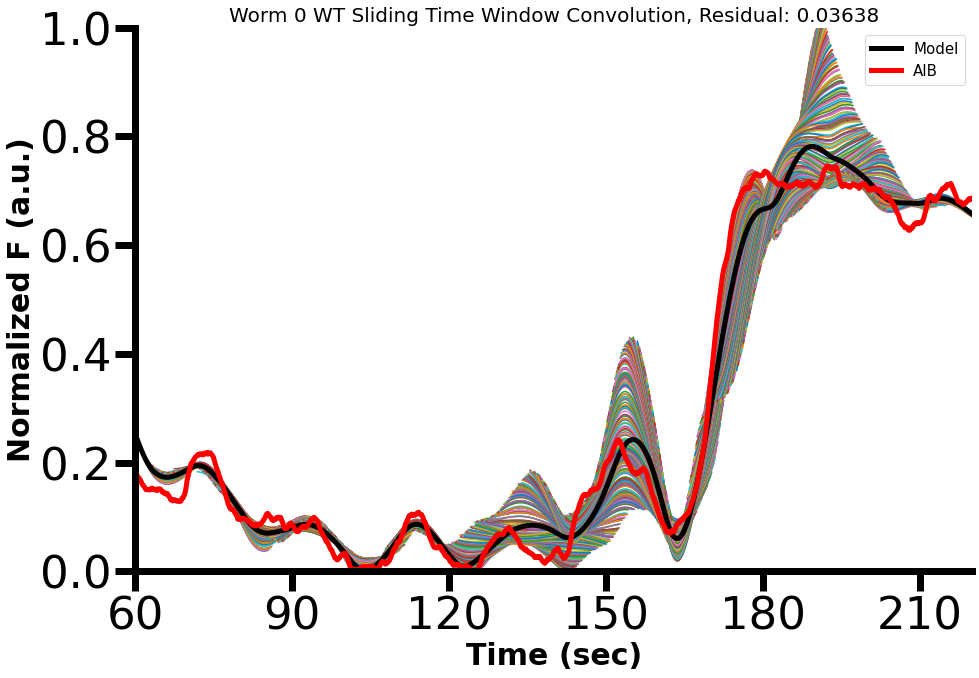

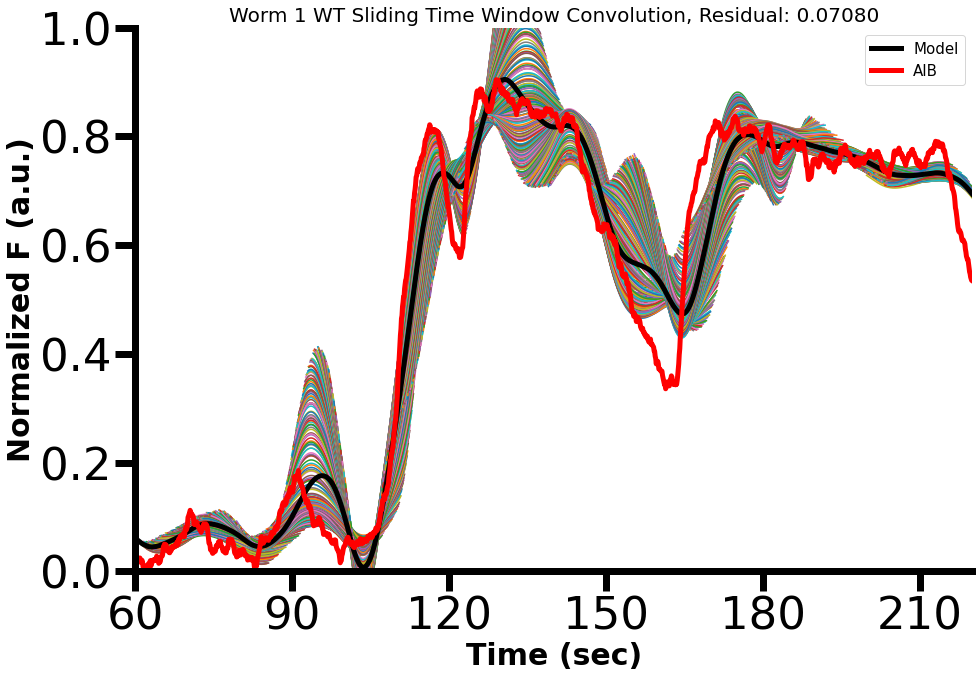

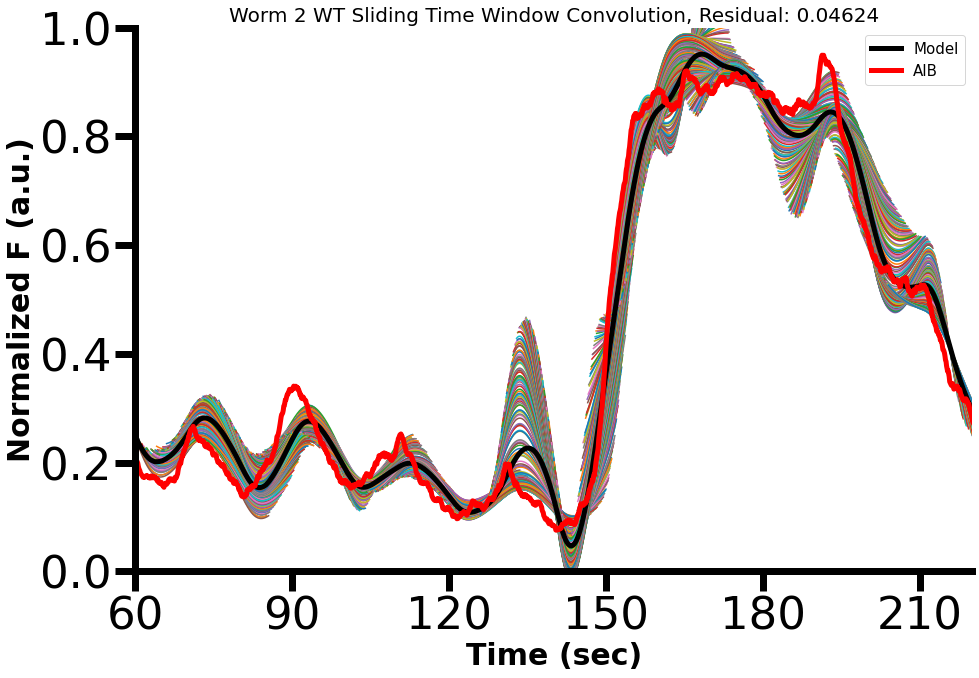

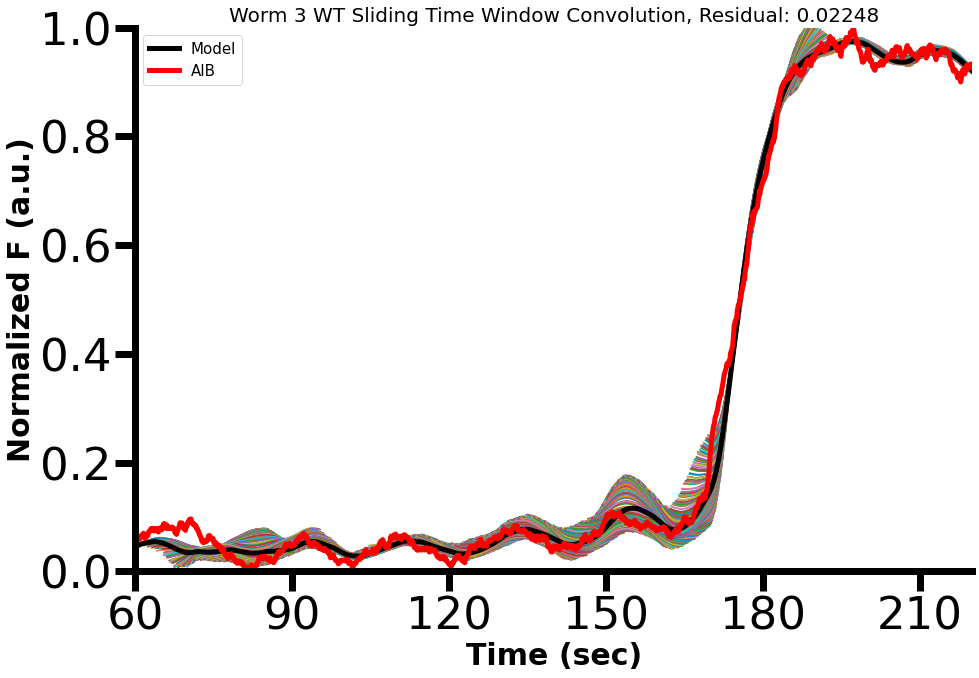

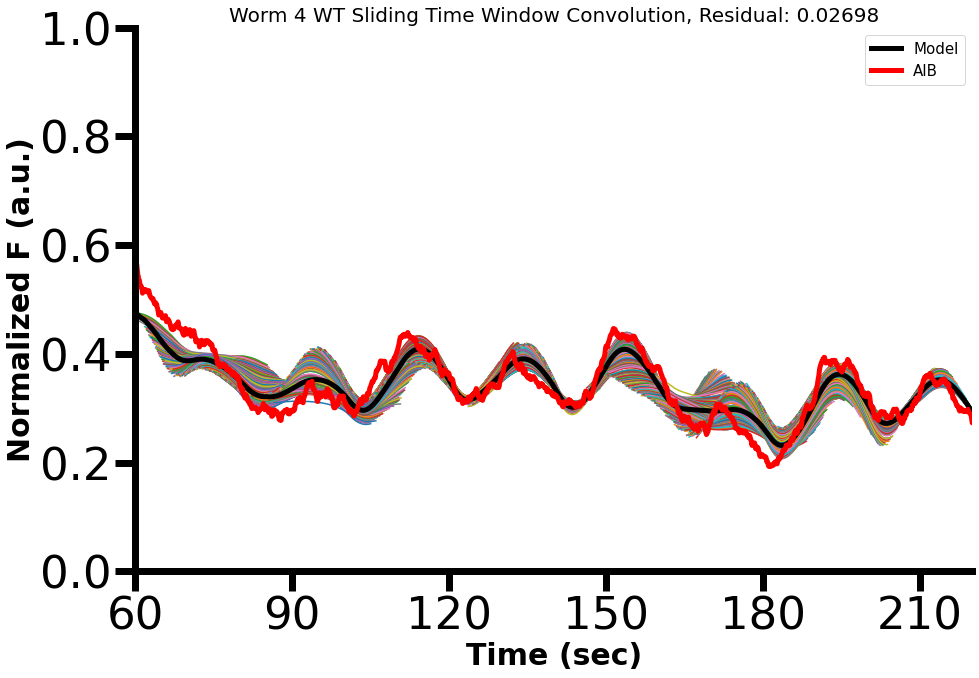

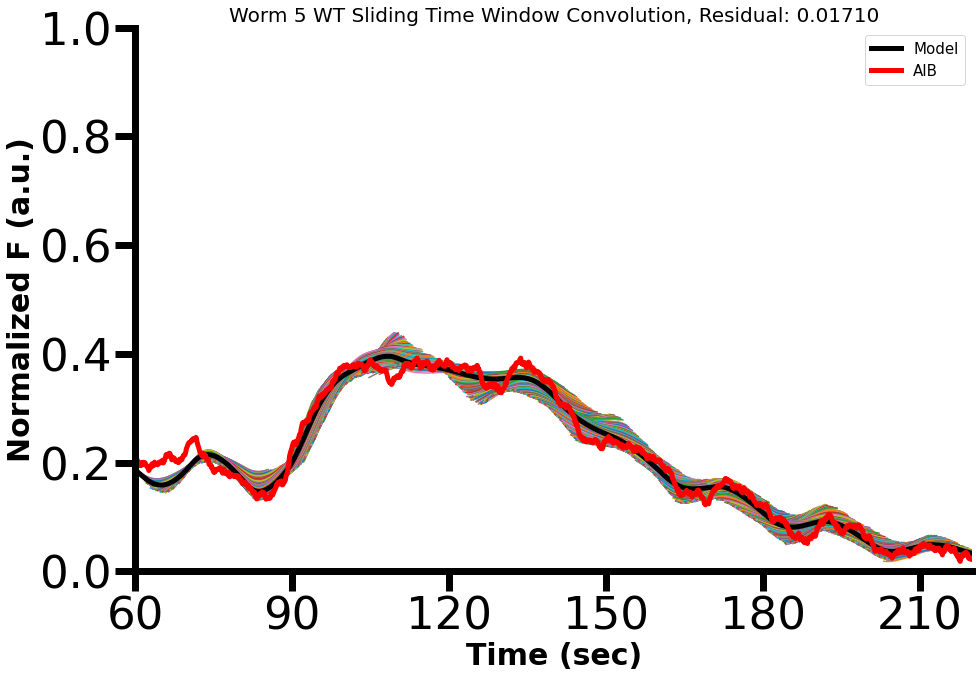

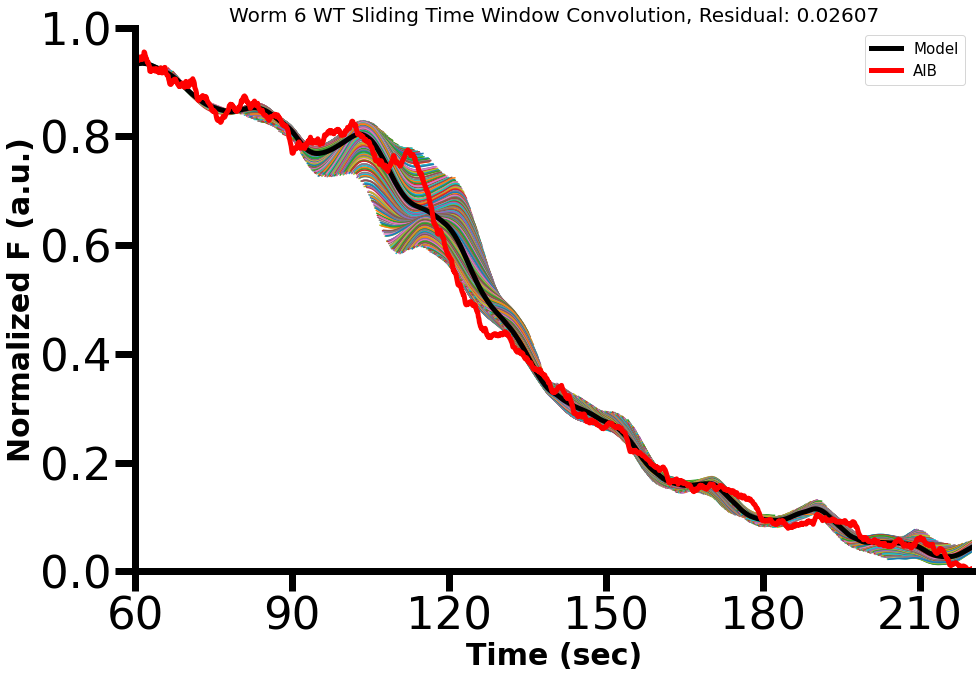

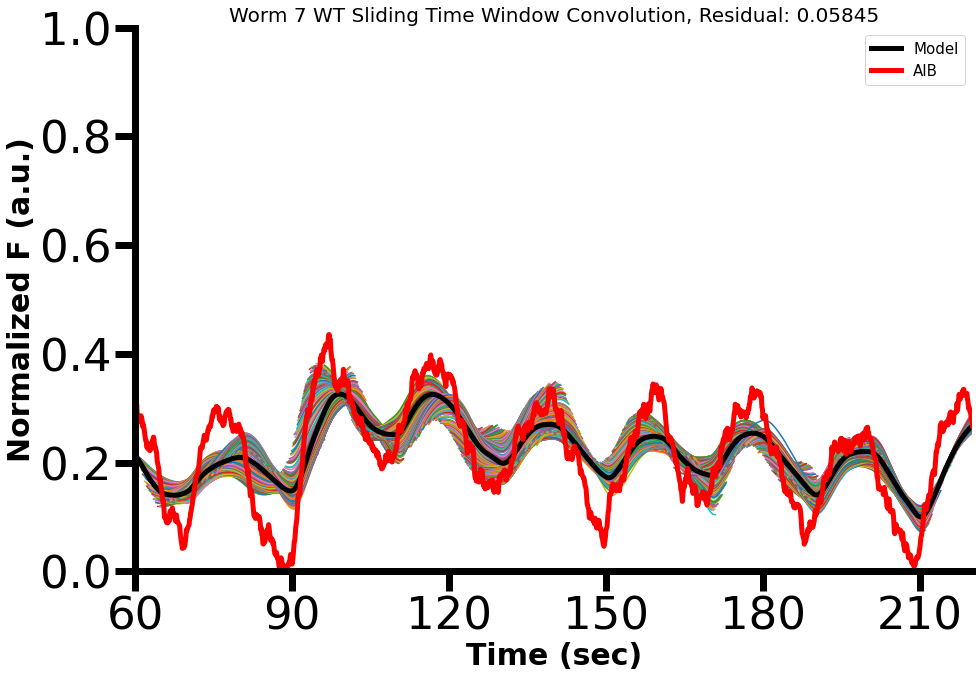

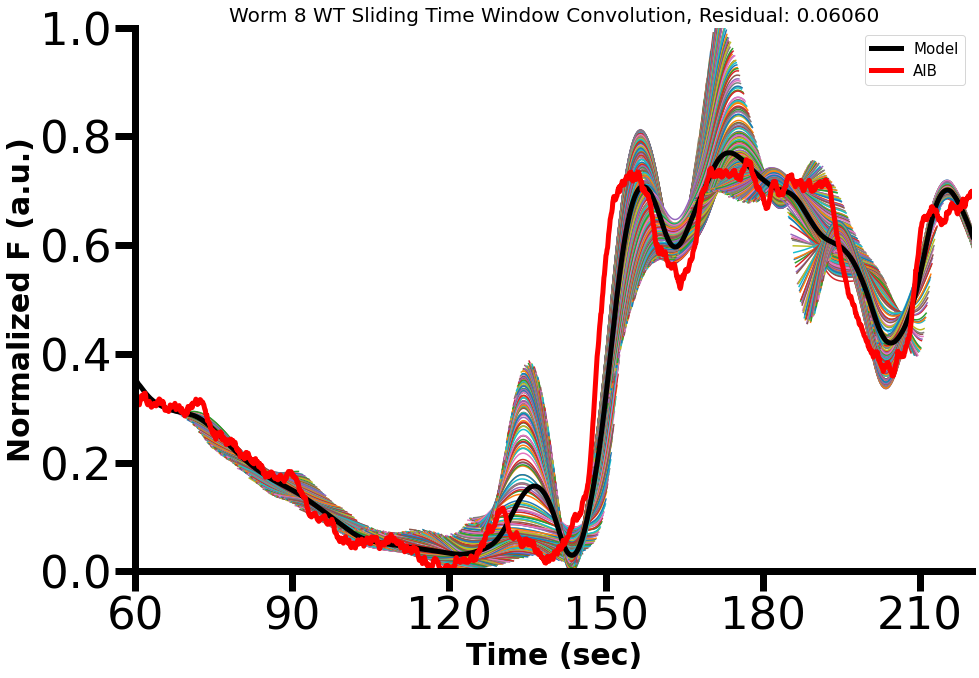

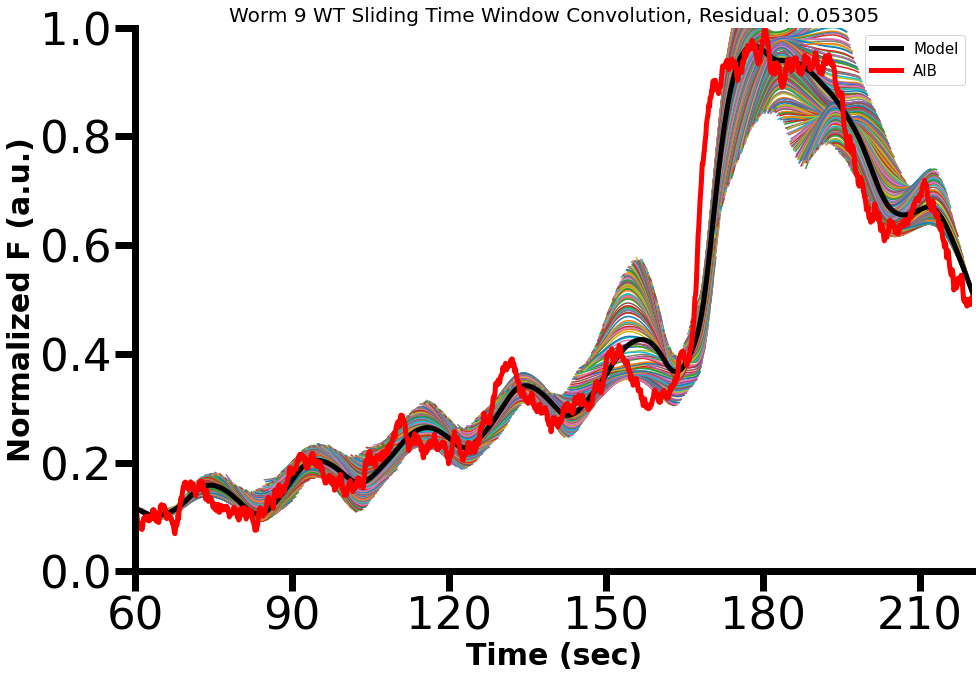

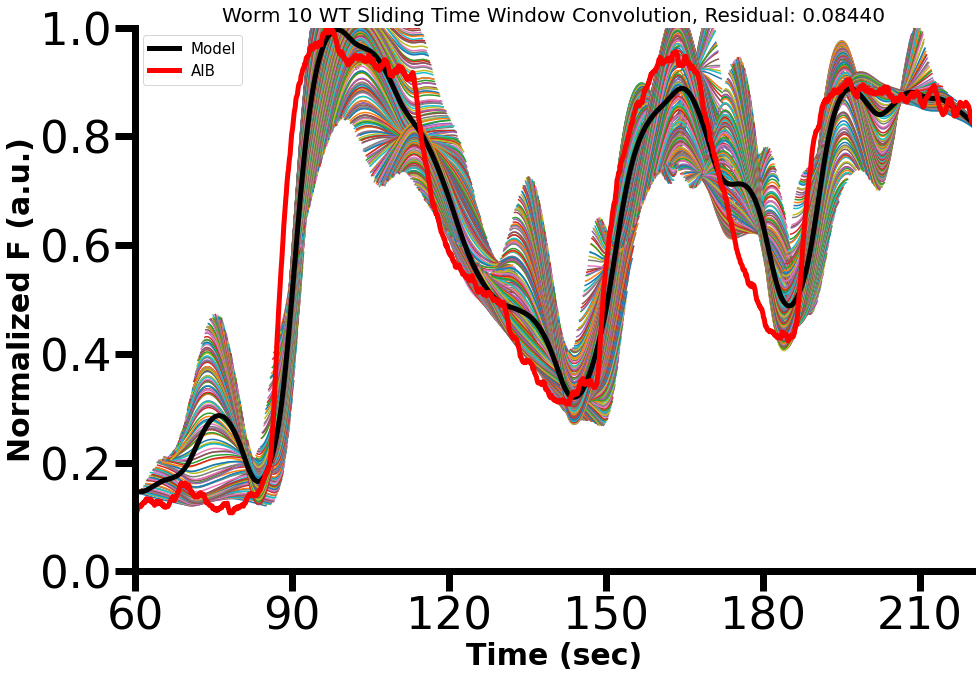

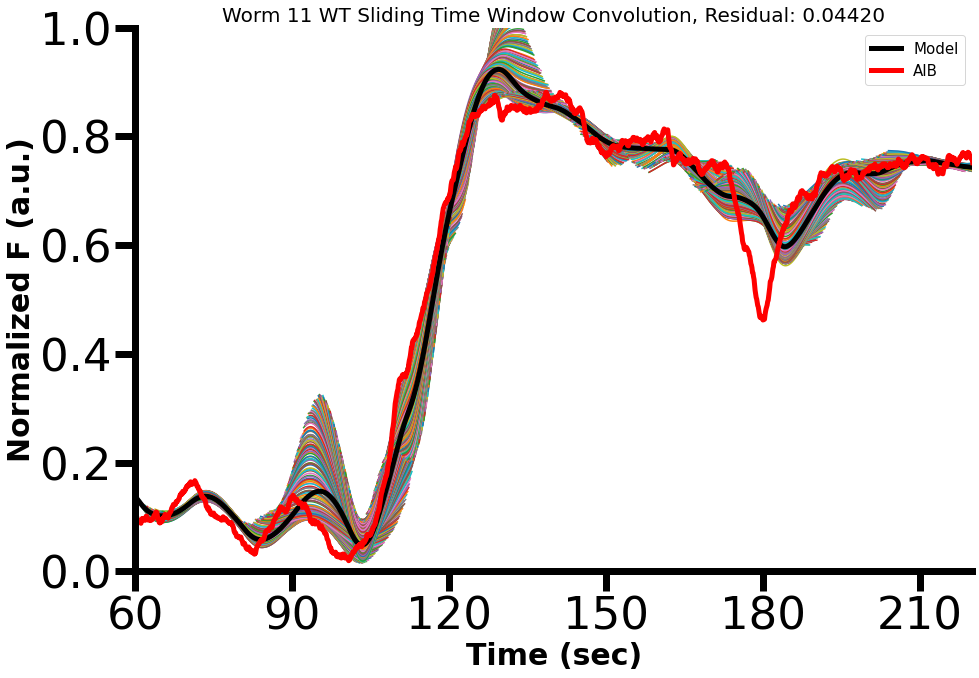

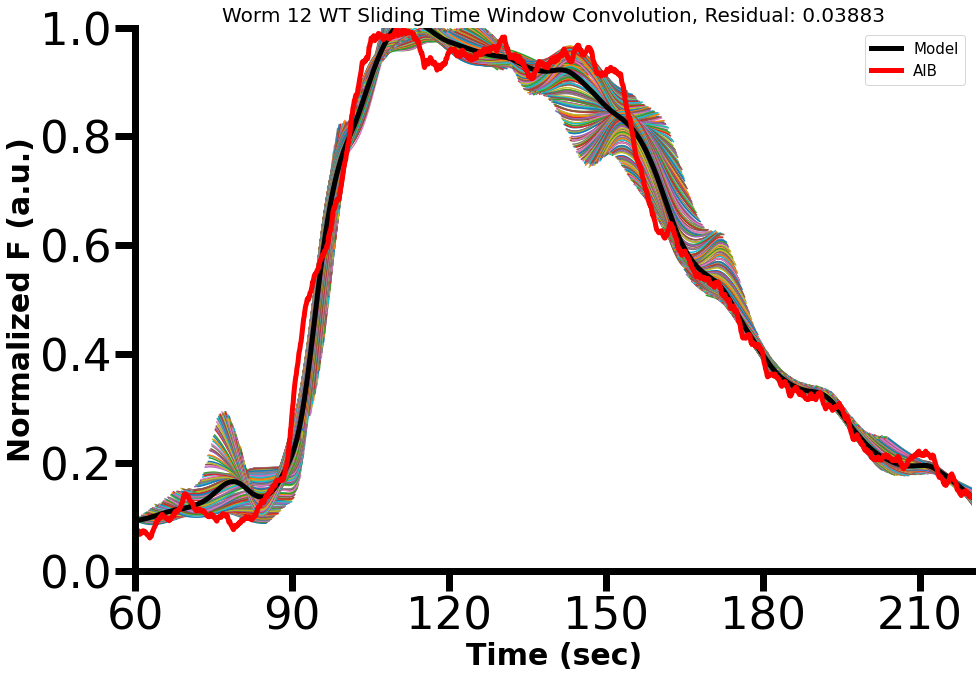

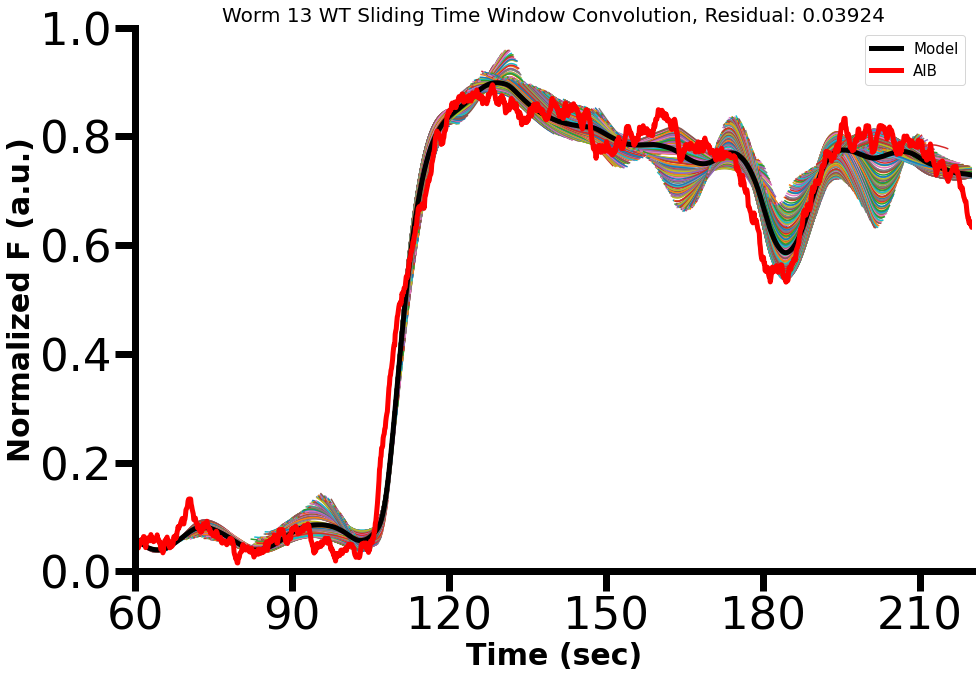

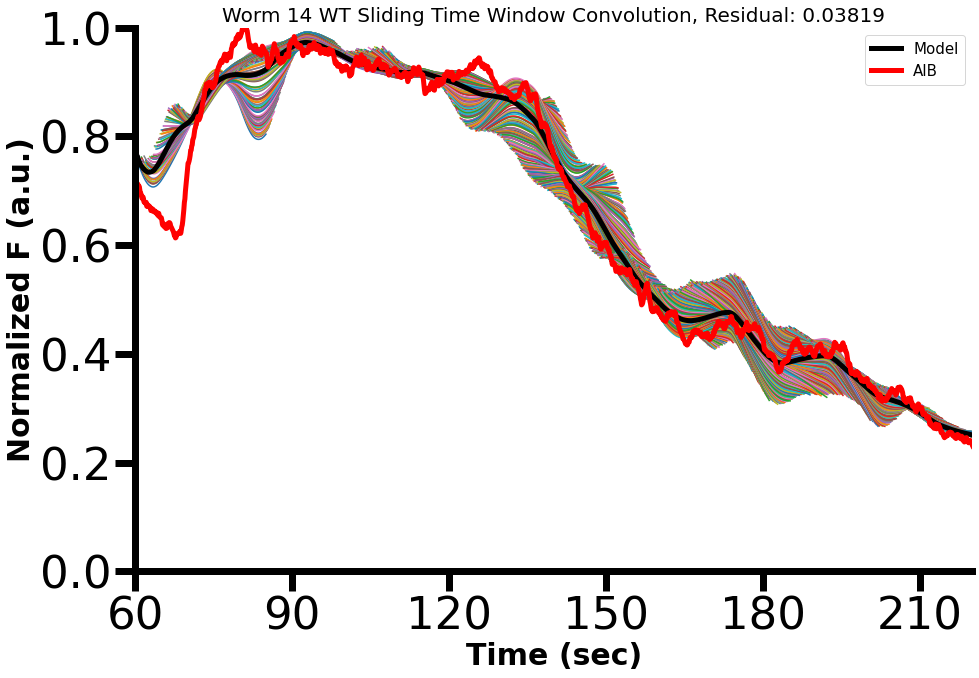

In [43]:
## - Model AIB data by using a sliding window convolution - ##

# Method uses downhill simplex method (Nelder-Mead) via scipy optimize to find the smallest residual between 
# model and real AIB. Need to seed the function first with some parameters (params) to help find optimum solution. 
# Due to similarity in alpha 1/2 values in kernels (see 'Modeling Neuron Data - Single Neuron Convolution.ipynb'
# code for details), we use the same fixed values, which are the median values from AVA-only modeling. 

# This function applies a sliding window on AWC and AIA sensory inputs, and their amplitudes are fit one frame at
# a time as the window shifts across the whole trace. After each fitting, AWC and AIA amplitudes are also divided
# by a single AVA amplitude value (obtained from the summation model, see 'Modeling Neuron Data - Summation.ipynb')
# for each worm.

# You can also have all 3 neuron inputs are floating, just add another line for AVA.
# We've done this to see how all 3 neurons are being integrated over time, just not shown in paper.
# You can also change it so that the neurons are not divided/normalized by AVA's amplitude

def Convolution_Sliding(AIB, AVA, AWC, AIA, AVA_amp, alpha1_input, alpha2_input, params, worm_num, plot_chunks):
    time = 250 # kernel time window, we found 250 frames to be a good time period
    t = np.arange(0, time)
    
    loss = time - 1 # this is how much is lost during convolution using 'valid' method (see below for details)
    # to align real AIB with model, we have to cut off the loss in the beginning (AIB[i][loss:])
    
    window = 500 # sliding time window, we found 500 frames to be a good time period
    # smaller window has finer resolution but will take longer, larger window will have lower resolution
    
    models = [] 
    AWC_slide_amp = []
    AIA_slide_amp = []
    res = [] 
    chunks_all = []
    
    def Model(AVA, AWC, AIA, AVA_amp, alpha1_input, alpha2_input, params):
        AWC_amp = params[0]
        AIA_amp = params[1]
        
        kernelAVA = AVA_amp * (np.exp(-alpha1_input*t) - np.exp(-alpha2_input*t))
        
        kernelAWC = (AWC_amp/AVA_amp) * (np.exp(-alpha1_input*t) - np.exp(-alpha2_input*t))
        kernelAIA = (AIA_amp/AVA_amp) * (np.exp(-alpha1_input*t) - np.exp(-alpha2_input*t))
        
        model = np.convolve(AVA,kernelAVA, 'valid') + np.convolve(AWC,kernelAWC, 'valid') + np.convolve(AIA,kernelAIA, 'valid') 
    
        # 'valid' method produces convolution where the beginning of the original trace is lost.
        # Loss is calculated by time window used (250) minus 1, so that resulting model is 249 frames less than 
        # original. This becomes important for plotting later to properly align model with original traces.
        
        return model
        
    for i in range(worm_num):
        print('Worm #: ', i) # can uncomment to show progress
        chunks = [] # going to save each convolved chunk acros the sliding time window
        count = 0
        
        for j in range(len(AIB[i])): # for each worm (i), loop through each frame of the trace
            def Res(params):
                model_AIB = Model(AVA[i][j:j+window], AWC[i][j:j+window], AIA[i][j:j+window], AVA_amp[i], 
                                  alpha1_input, alpha2_input, params)
                # here is where we implement the sliding window. Loop through each neuron trace the length of the 
                # window then we can shift by a frame a time and convolve across the next window of time

                # Residual:
                # take difference of real vs model AIB within the window, square it, divide it by number of frames, 
                # then take square root
                Residual = np.sqrt(np.sum(np.subtract(AIB[i][j+loss:j+window],model_AIB)**2) / len(model_AIB))
                return Residual

            optimize = minimize(Res, params, method='Nelder-Mead') # optimizing for smallest solution (residual)
            parameters_new = optimize['x'] # final new parameters based on optimization
            AWC_slide_amp.append(parameters_new[0])
            AIA_slide_amp.append(parameters_new[1])
            new_model = Model(AVA[i][j:j+window], AWC[i][j:j+window], AIA[i][j:j+window], AVA_amp[i], 
                              alpha1_input, alpha2_input, parameters_new)
            
            # want to save model padded with nans to save its place in terms of shifting windows
            nans = np.array([np.nan]*len(AIB[i]))
            nans[j:j+len(new_model)] = new_model
            chunks.append(nans)
            if count == (len(AIB[i])-window):
                break
                # break cycle when you get to the end - if window exceeds final frame, stop
            
            count += 1
            
        chunks_all.append(chunks)    
        chunk_avg = np.nanmean(chunks, axis=0) # average all chunks that are padded with nans, while ignoring nans
        final_model = chunk_avg[:len(AIB[i][loss:])] # because the convolution has loss, and the sliding window
        # starts at the beginning, cut off the beginning to match the length of model
        models.append(final_model) # save resulting model, which is the averaged chunks
        
        # Residual saved above is just for each chunk in sliding window, need full model trace to compare for
        # real residual between real AIB and model AIB
        Residual_final = np.sqrt(np.sum(np.subtract(AIB[i][loss:],final_model)**2) / len(final_model))
        res.append(Residual_final)

    if plot_chunks == 'yes': #input 'yes' if you want to visualize all the chunks
        # chunks will be in colors, model will be black
        timeplot = []
        for t in range(600,2291):
            temp = t/10
            timeplot.append(temp)
            
        for w in range(worm_num):
            fig, ax = plt.subplots(1,1, figsize=(15,10), facecolor='w') 
            plt.rcParams["axes.edgecolor"] = "black"
            plt.rcParams["axes.linewidth"] = 7
            ax.set_title('Worm '+str(w)+' WT Sliding Time Window Convolution, Residual: '+str(res[w])[:7], fontsize=20)
            for c in chunks_all[w]:
                ax.plot(timeplot, c[:len(AIB[w][loss:])])
            ax.plot(timeplot, models[w], color = 'black', linewidth=5, label = 'Model')
            ax.plot(timeplot, AIB[w][loss:], color = 'red', linewidth=5, label = 'AIB')
            ax.tick_params(axis= 'both', labelsize=45, length=20, width=7)
            ax.set_ylabel('Normalized F (a.u.)', fontsize=30, weight='bold')
            ax.set_xlabel('Time (sec)', fontsize=30, weight='bold')
            ax.legend(loc='best', fontsize=15)
            ax.set_ylim([0,1])
            ax.set_xlim([60,220])
            plt.xticks(np.arange(60, 220, step=30))
            for spine in ['top', 'right']:
                ax.spines[spine].set_visible(False)
            #plt.savefig('Sliding chunks.svg')

    return res, models, AWC_slide_amp, AIA_slide_amp

p_slide = [0.09, 0.09] 
# Parameters used for seeding initial optimization. Order corresponds to order of neurons
# These were determined through a series of tests. Seeded values too far off can sometimes result in the 
# model getting stuck in local minima. Feel free to try others. AIA works well with more negative numbers. 

# I will only show WT modeling here, and I'm using odor+red light (both) experiments for full AWC and AIA
# activation for modeling. Try other versions for yourself :)

# *** for 'worm_num' input below, I'm just showing 1 worm because the code take a while to run. 
# change to above WT_worm_num to model all the worms
WT_slide = Convolution_Sliding(WT_AIB_both, WT_AVA_both, WT_AWC_both_avg, WT_AIA_both, WT_AVA_sum_amps, 
                             WT_AVA_only_params['Alpha1 Both'], WT_AVA_only_params['Alpha2 Both'], p_slide, 
                               1, 'yes') # *** change 1 to WT_worm_num if you want to apply to all
WT_slide_res = WT_slide[0]
WT_slide_models = WT_slide[1]
WT_slide_AWC_amp = WT_slide[2]
WT_slide_AIA_amp = WT_slide[3]
print('Done')

# - Save Residual - #
np.save('WT Slide Residual.npy', WT_slide_res)


[0.03638139733480866, 0.0708089733480669, 0.04624365389831919, 0.02248475919215296, 0.02698832197782896, 0.017102373335441668, 0.026071616133345188, 0.05845369167478385, 0.06060444666431796, 0.05305590005666114, 0.08440689661848728, 0.04420711611875104, 0.03883879930700398, 0.03924915310630736, 0.03819091258947954]


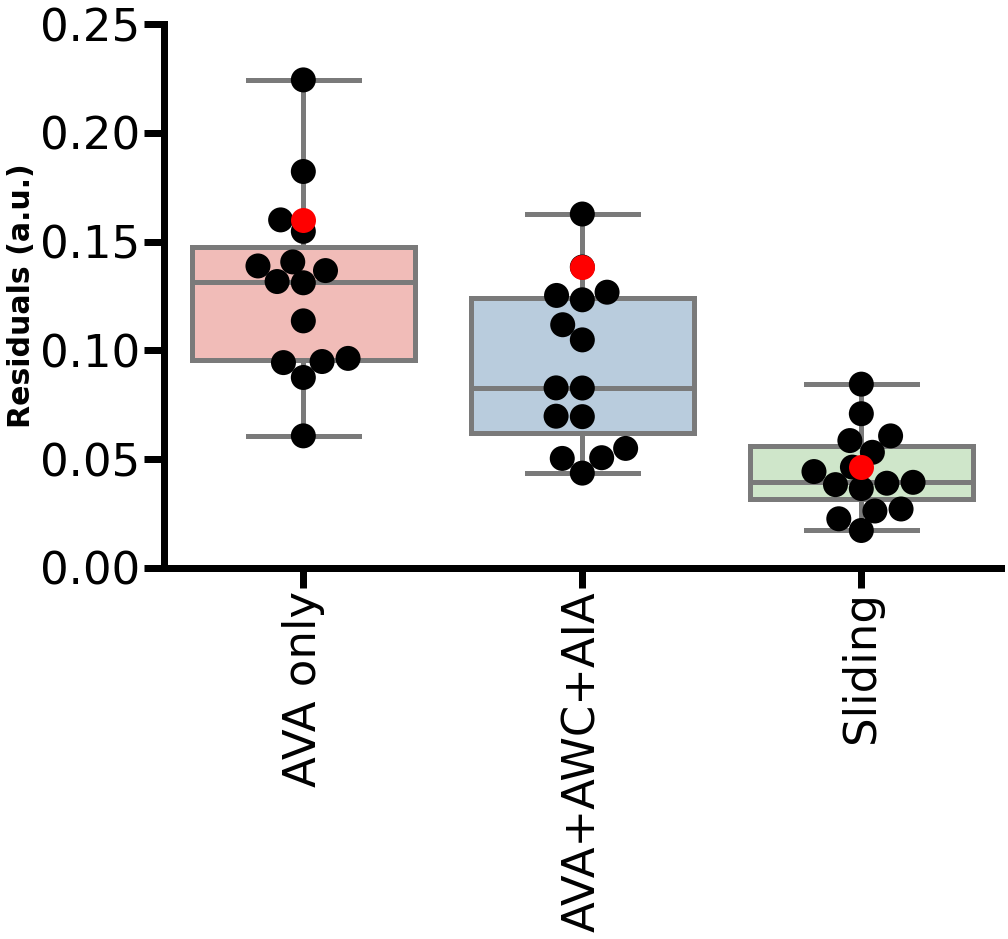

In [44]:
## Plotting Residuals for Comparison ##
# Just showing WT ignored models for simplicity 

# Import previously saved AVA-only residuals from previous modeling 
# (see 'Modeling Neuron Data - Single Neuron Convolution.ipynb' code)
WT_AVA_only_res = np.load('WT AVA Only Residuals.npy', allow_pickle=True).item()

# Import previously saved AVA+AWC+AIA residuals from previous modeling 
# (see 'Modeling Neuron Data - Summation.ipynb' code)
WT_sum_res = np.load('WT Sum Residual.npy')

print(WT_slide_res)

data = np.array([ WT_AVA_only_res['Residual Both'], WT_sum_res, WT_slide_res])
labels = ['AVA only','AVA+AWC+AIA', 'Sliding']

dF_slide = pd.DataFrame(data.T, columns=labels)

colors = sns.color_palette("Pastel1")

fig, ax = plt.subplots(1,1, figsize=(15,10), facecolor='w')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 7
sns.boxplot(data=dF_slide,linewidth = 5, palette = colors)
sns.swarmplot(data=dF_slide, size=25, color = 'black')
sns.swarmplot(data=dF_slide.loc[[2]], size=25, color='red')
# highlights specific trace I used in paper (worm index #2)
# note this actually duplicates the datapoint, so I just use it to visualize
plt.xticks(rotation=90)
ax.set_ylabel('Residuals (a.u.)', fontsize=30, weight='bold')
ax.set_ylim([0,0.25])
ax.tick_params(axis= 'both', labelsize=45, length=20, width=7)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

In [45]:
## Statistics ##

from scipy.stats import mannwhitneyu 
# mann-whitney U is for unpaired samples (between WT and HisCl/red light (silenced) exps)

from scipy.stats import wilcoxon 
# wilcoxon is for paired samples (across all WT models)

def Stats_model(choice, sample1, sample2, name):
    
    if choice == 'wilcoxon':
        new_array = []
        for i in range(len(sample1)):
            diff = sample1[i] - sample2[i]
            rounded = np.round(diff, decimals=2)
            new_array.append(rounded)
        w = wilcoxon(new_array, y=None)
        p = w.pvalue
    if choice == 'mannwhitney':   
        U, p = mannwhitneyu(sample1, sample2)
    
    if p < 0.001:
        print(name, '***', p)
    elif p < 0.01:
        print(name, '**', p)
    elif p < 0.05:
        print(name, '*', p)
    elif p > 0.05:
        print(name, 'NS', p)
        
    return p

# Compare this sliding residual with previous AVA-only and Summation residuals (imported above) #

p1 = Stats_model('wilcoxon', WT_AVA_only_res['Residual Both'], WT_sum_res, 'AVA-only vs AVA+AWC+AIA')
p2 = Stats_model('wilcoxon', WT_AVA_only_res['Residual Both'], WT_slide_res, 'AVA-only vs Slide')
p3 = Stats_model('wilcoxon', WT_sum_res, WT_slide_res, 'AVA+AWC+AIA vs Slide')


AVA-only vs AVA+AWC+AIA ** 0.001410512473214279
AVA-only vs Slide *** 6.103515625e-05
AVA+AWC+AIA vs Slide *** 6.103515625e-05


/Users/lotus/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [46]:
## Holm-Bonferroni Correction of Residuals ##
# This is a multiple comparison test between all p-values to correct for any potential statistical errors and
# false significance. This returns new, adjusted p-values based on the provided group of tests (ie all the WT exps)
# Bonferroni is a more stringent test, and Holm is a variation that is more tailored to your data.

import statsmodels.stats.multitest as multi

WT_pvals = [p1, p2, p3]
print(multi.multipletests(WT_pvals, alpha=0.05, method='holm', is_sorted=False, returnsorted=False))
# Displays True/False statements of significance, followed by new corrected p values.

(array([ True,  True,  True]), array([0.00141051, 0.00018311, 0.00018311]), 0.016952427508441503, 0.016666666666666666)


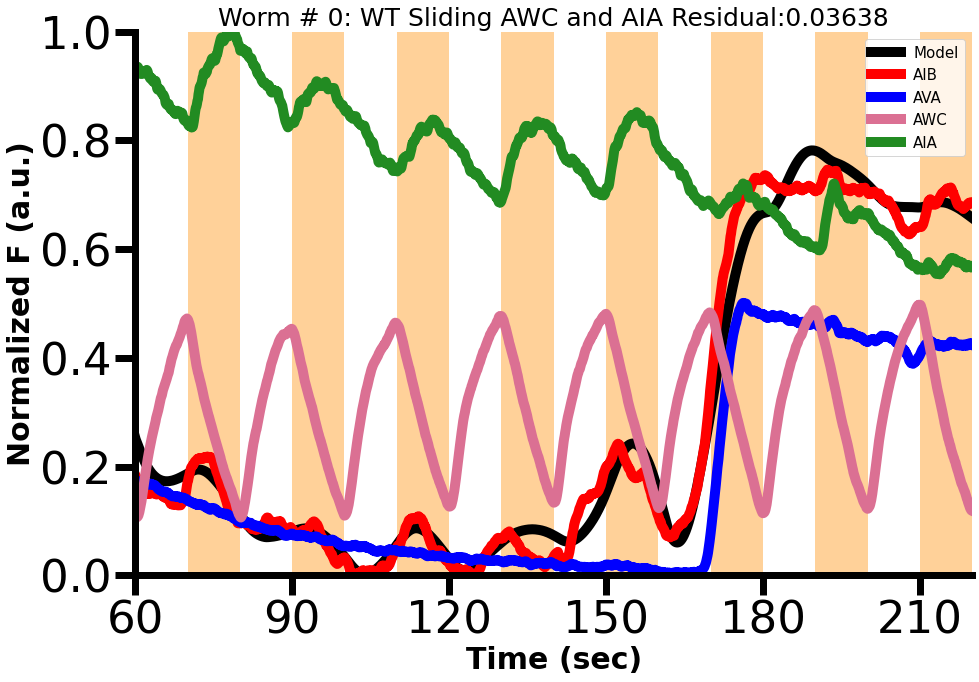

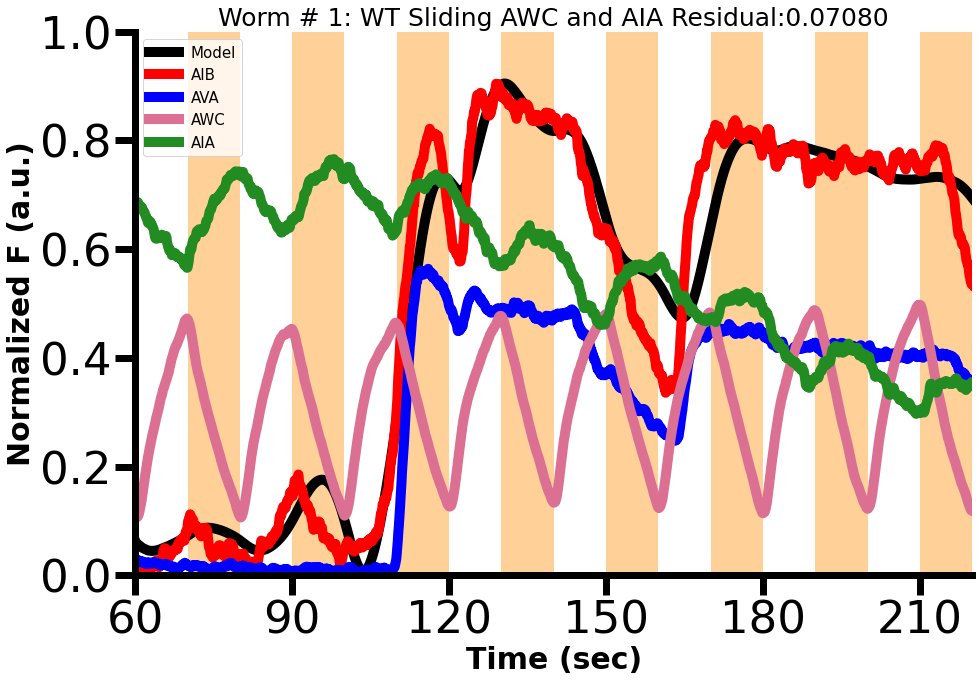

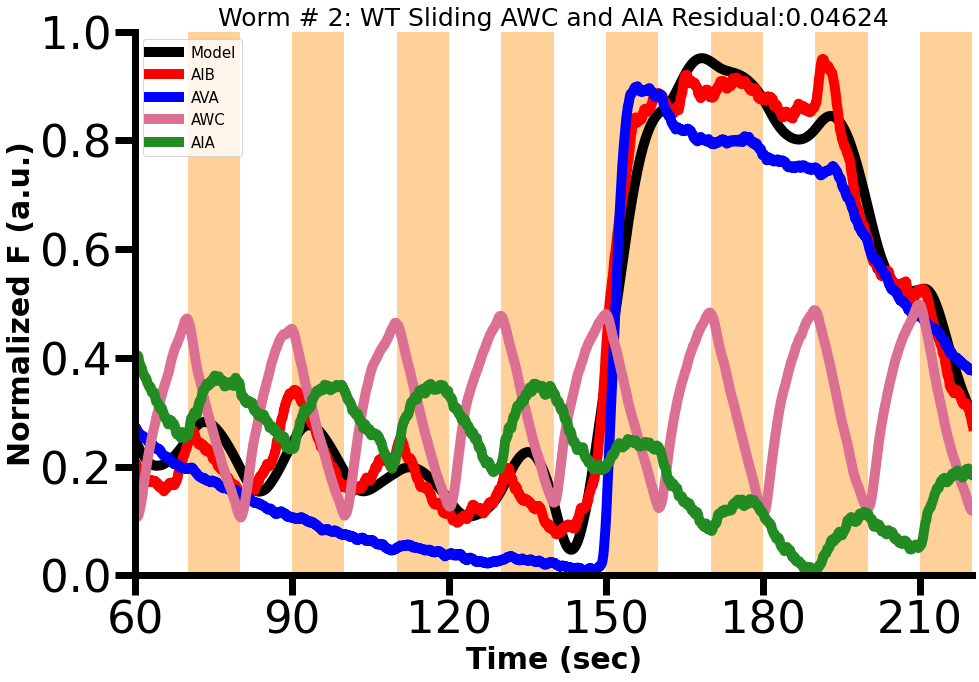

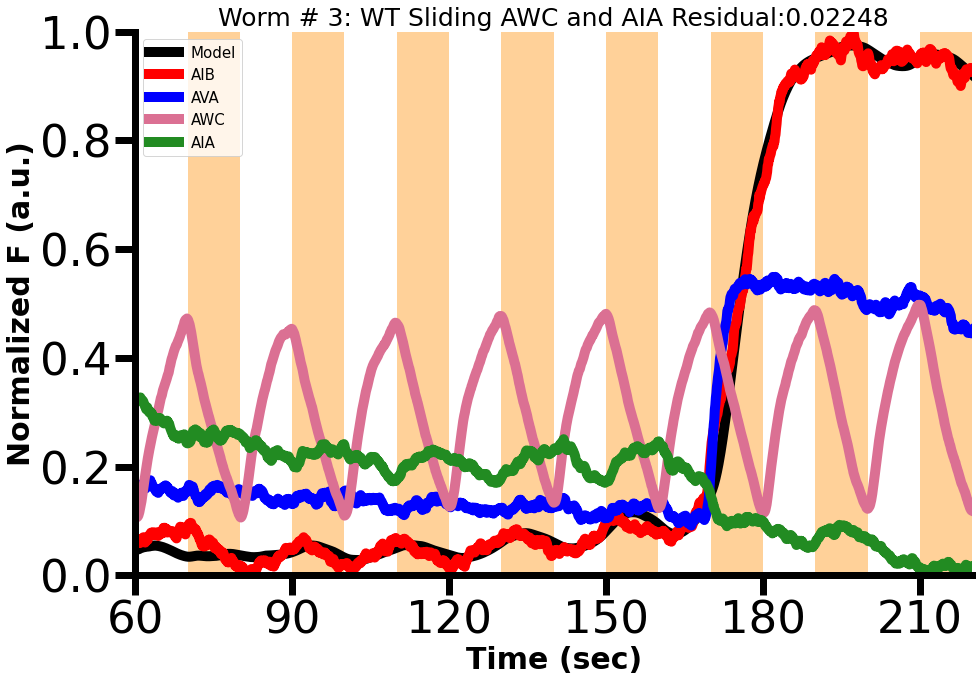

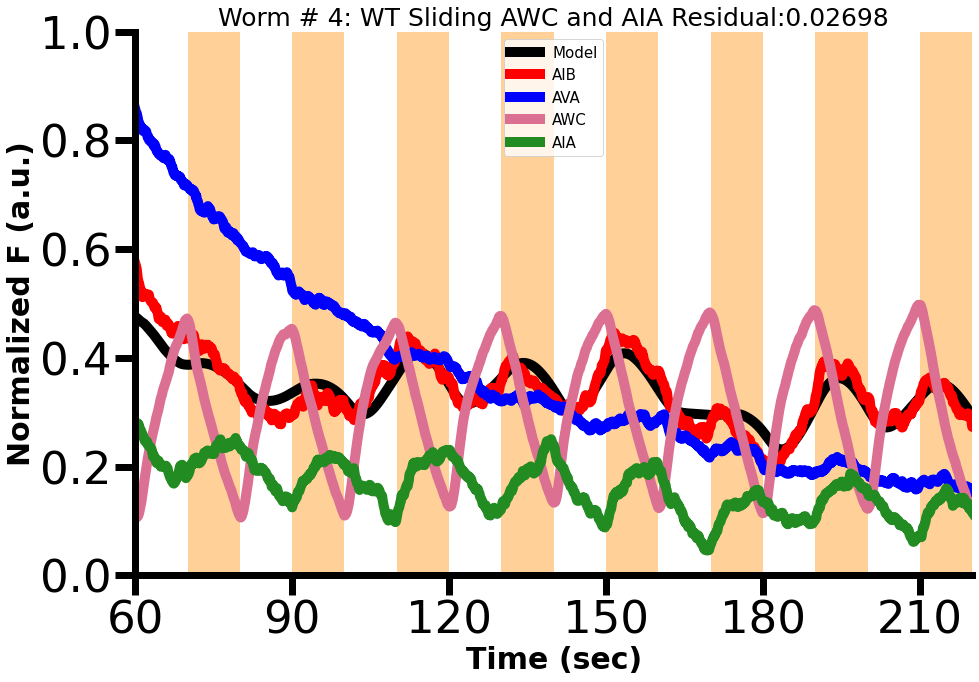

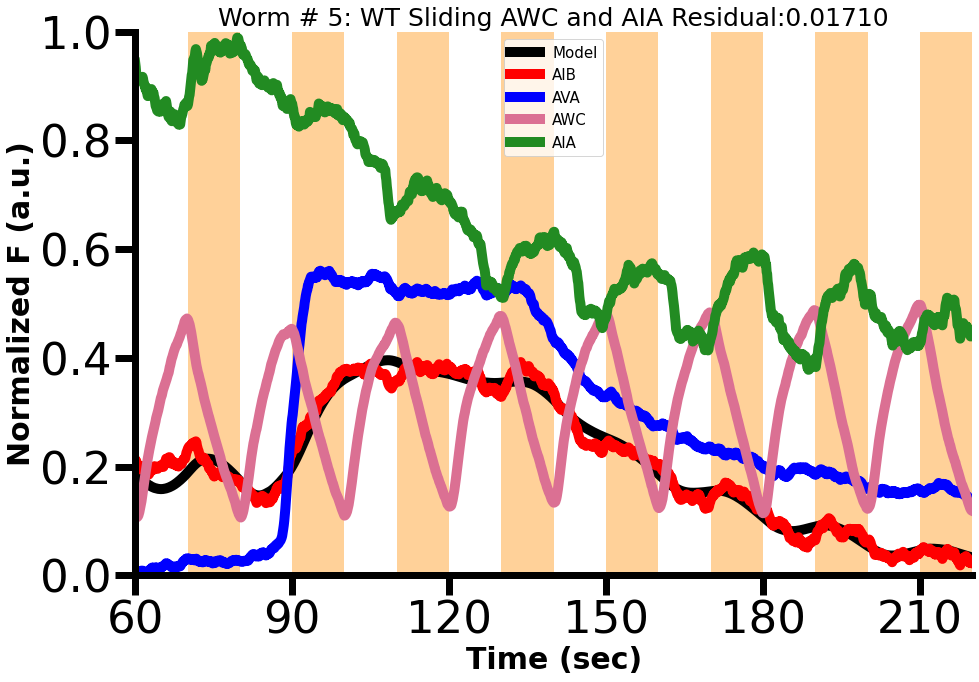

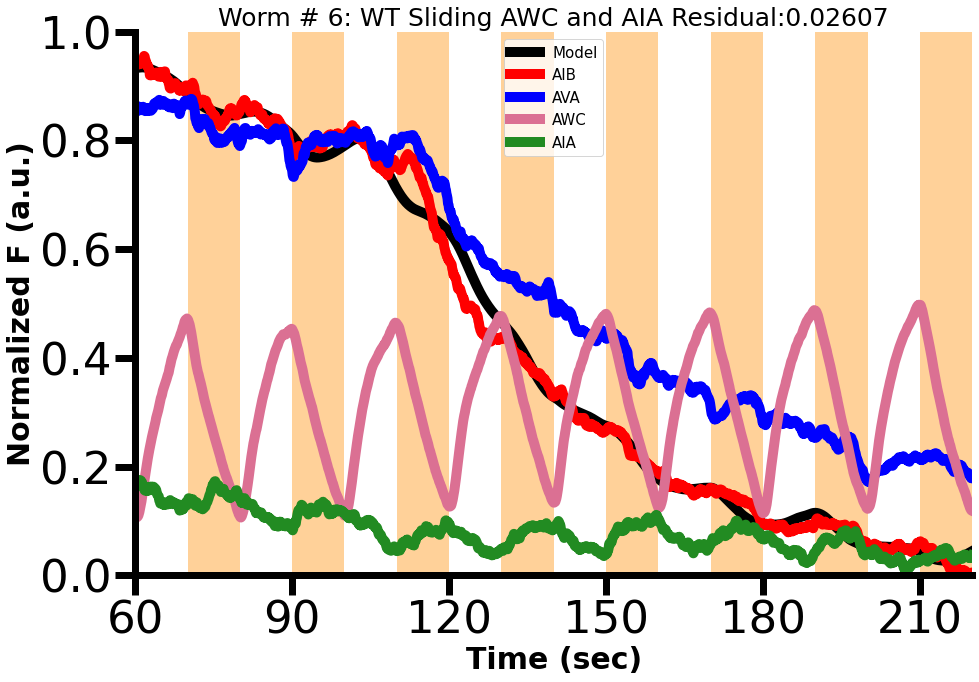

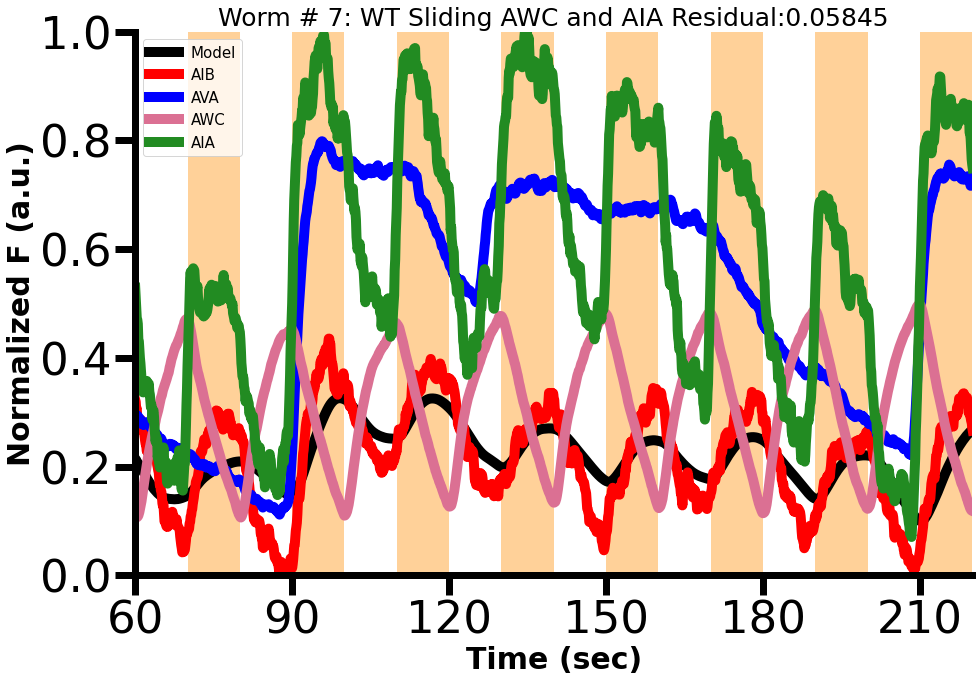

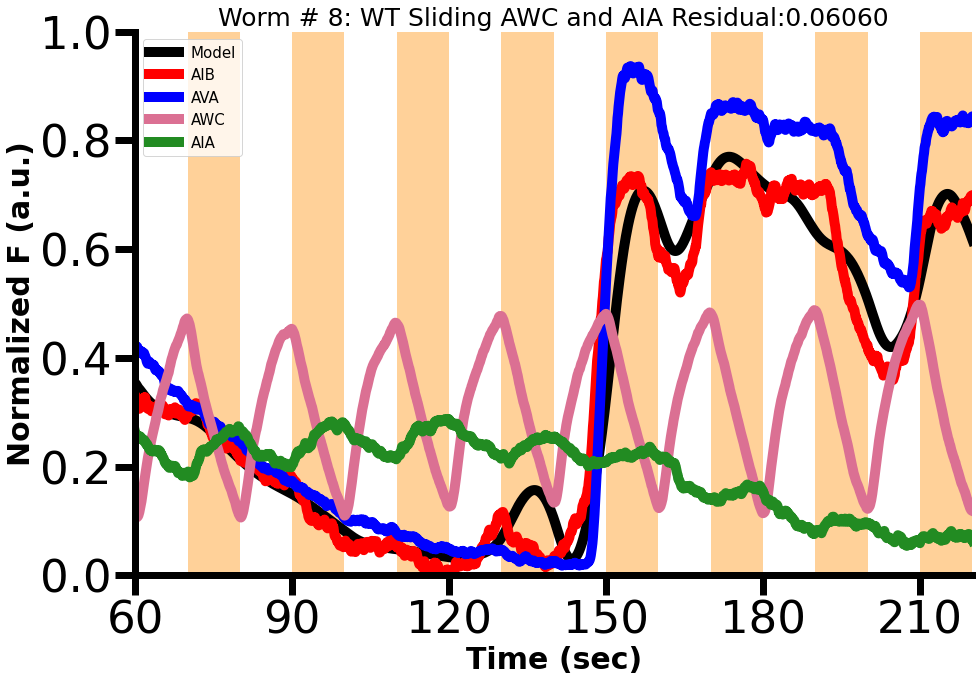

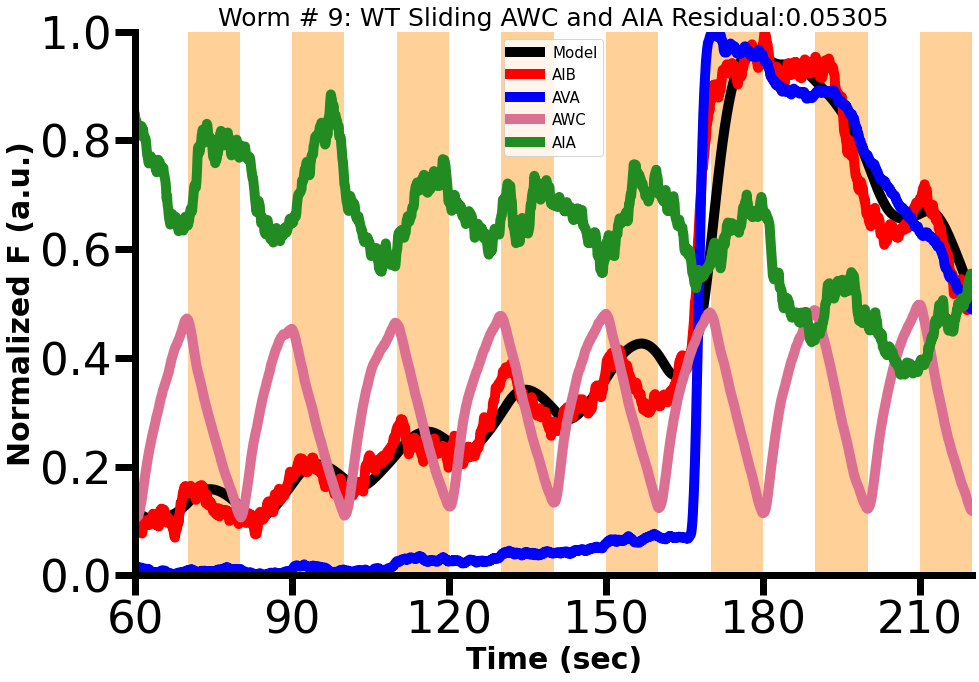

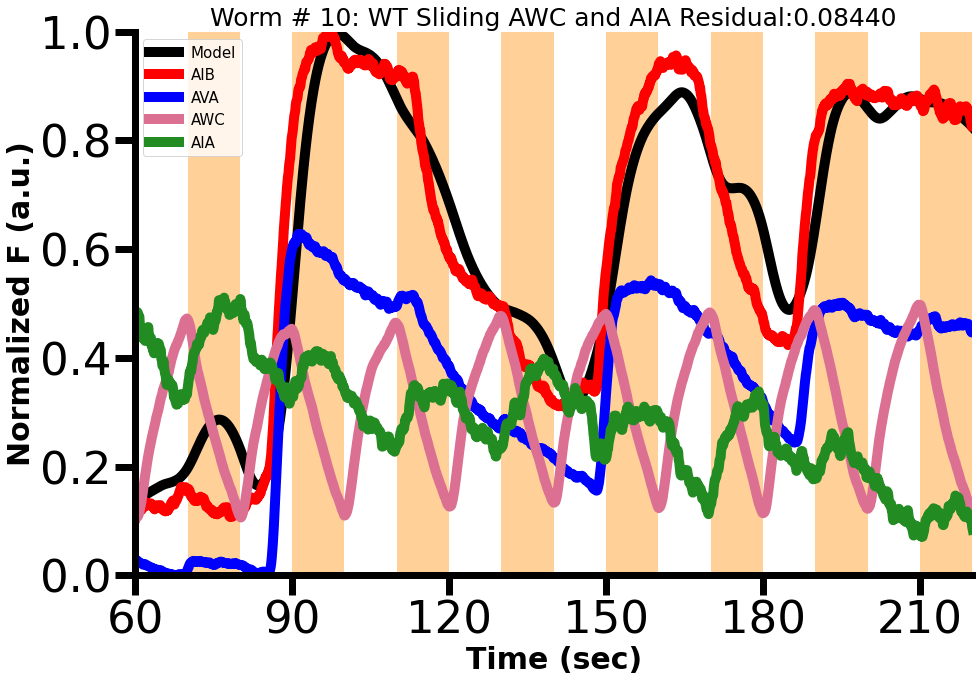

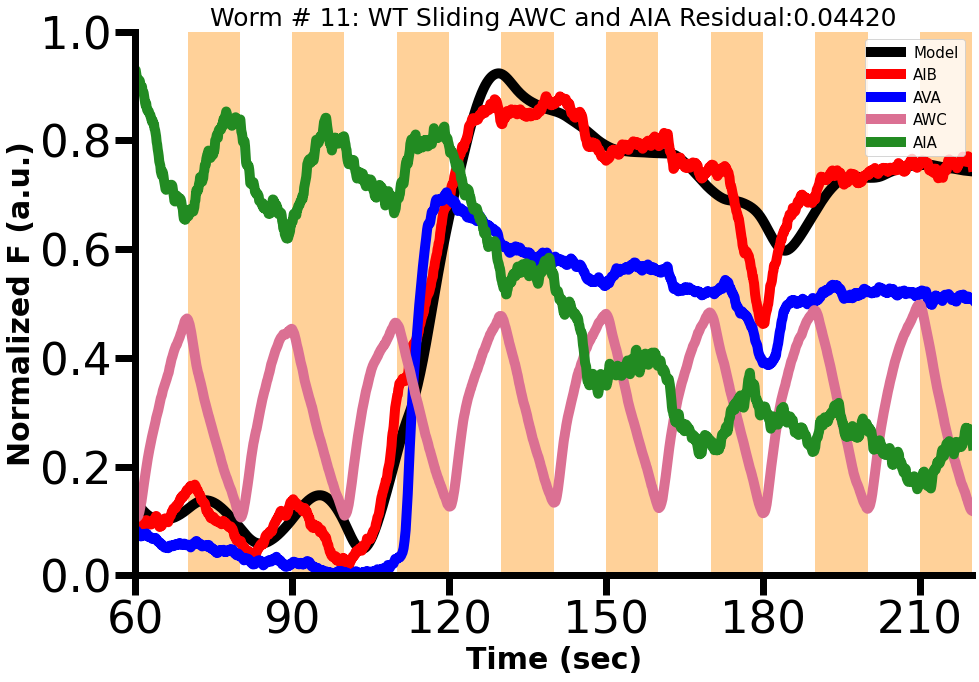

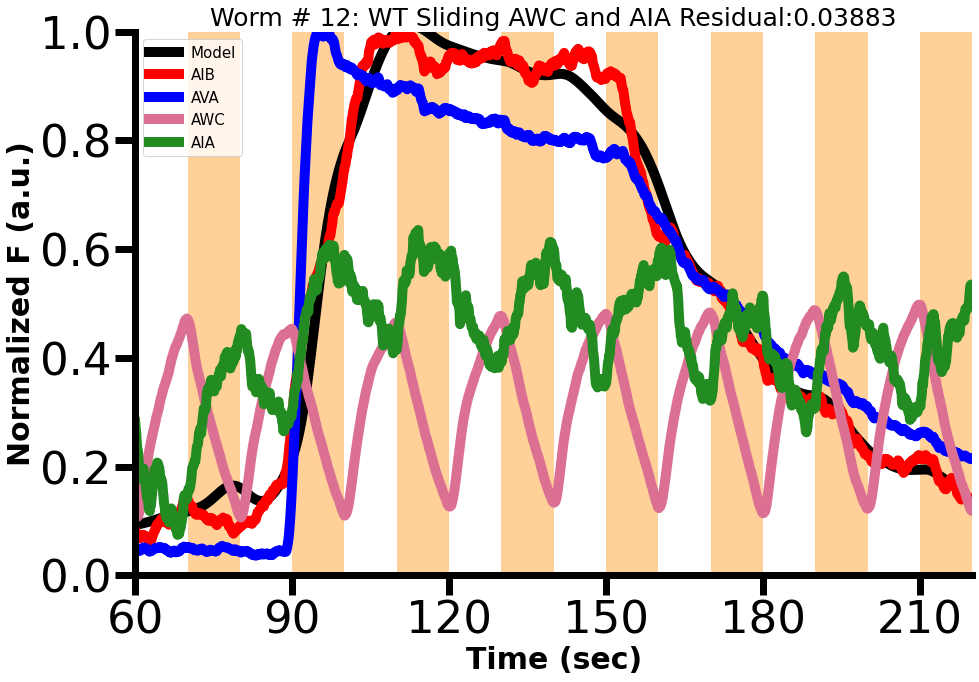

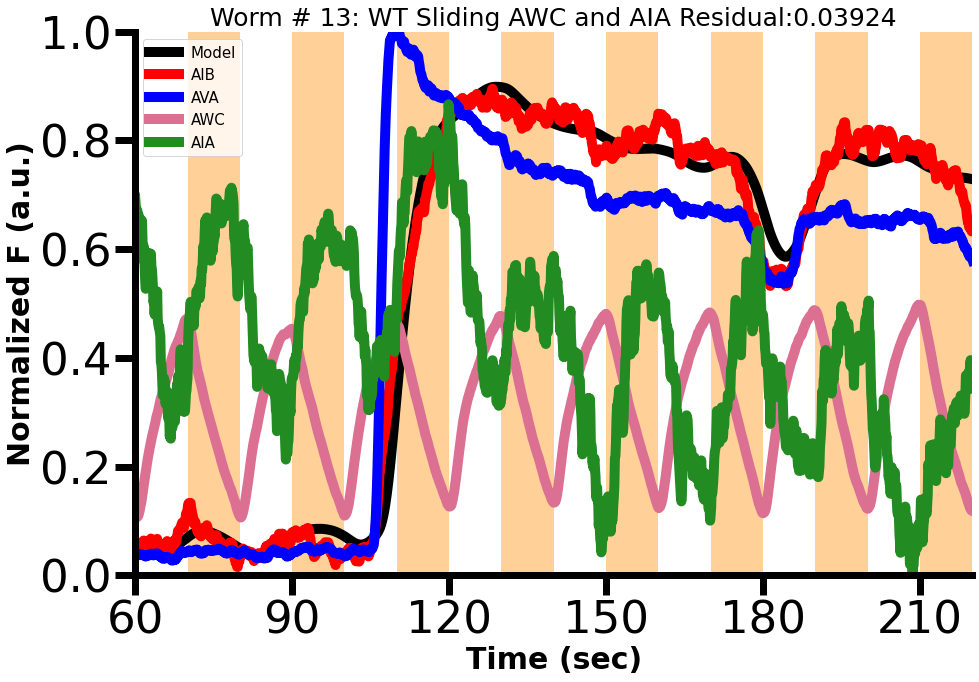

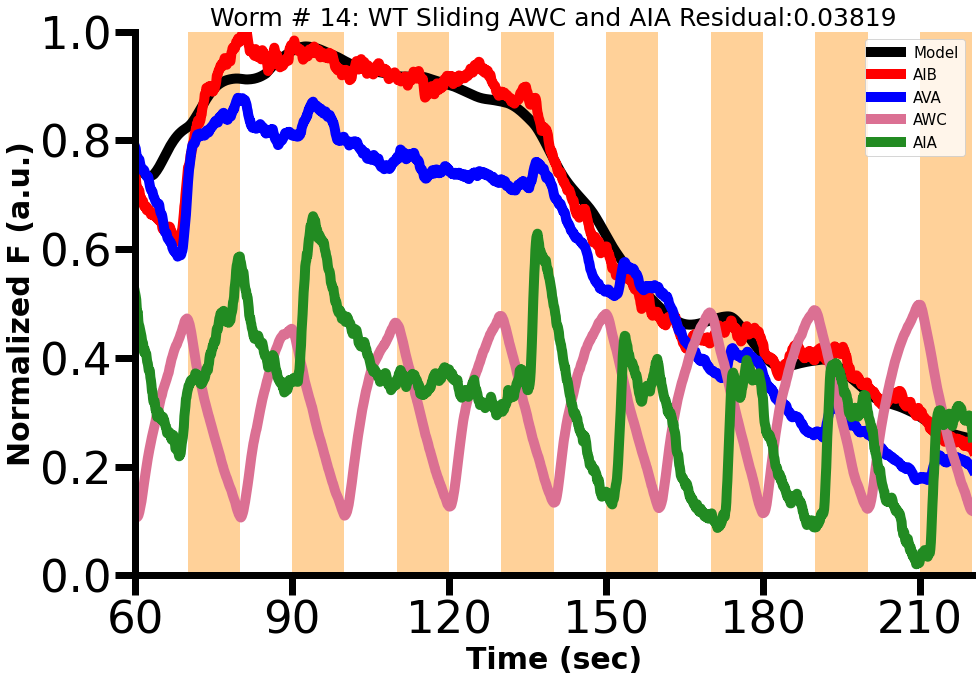

In [12]:
## - Plotting Traces and Model - ##
# Will just show odor+red light experiments as examples. 
# Note that when plotting normalized neuron traces with model, that the modeling process cuts off the first
# 249 frames, so to align neuron traces with model trace, need to cut off neuron trace AIB[249:]


# Easier to change between worms/exps this way
worm_num = WT_worm_num # 15 for WT, 12 for ins_hiscl, 20 for nmr_hiscl
residual_plot = WT_slide_res
model_plot = WT_slide_models
aib_plot = WT_AIB_both 
ava_plot = WT_AVA_both
awc_plot = WT_AWC_both_avg
aia_plot = WT_AIA_both
title_name = 'WT Sliding AWC and AIA'


# This is to plot in seconds (10 fps). Sort of complicated, but normalization cuts off 350 frames in beginning, 
# and convolution process cuts off an additional 249 frames (time window - 1) in beginning, totaling 599 frames. 
# I rounded it up to 600, and added the extra 1 frame shift to the end for simplicity, because I cut off the
# last 90 frames. There is originally a total of 2300 frames, but the smoothing process (5 frames x2) cuts off 10,
# so new length is 2290 (plus the 1 extra frame shift I added to help round the beginning). Thus, 600,2291.
# This is all just for publication and for transparency of where the ACTUAL time starts in my raw traces.
# Feel free to change to time that makes more sense lol :) 
timeplot = []
for t in range(600,2291): 
    temp = t/10
    timeplot.append(temp)

for i in range(worm_num):
    fig, ax = plt.subplots(1,1, figsize=(15,10), facecolor='w') 
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 7
    ax.set_title('Worm # '+str(i) + ': '+ title_name + ' Residual:'+str(residual_plot[i])[:7], fontsize=25)
    ax.plot(timeplot, model_plot[i], color = 'black', linewidth=10, label='Model')
    ax.plot(timeplot, aib_plot[i][249:], color = 'red', linewidth=10, alpha=1, label='AIB') 
    ax.plot(timeplot, ava_plot[i][249:], color = 'blue', linewidth=10, alpha=1, label='AVA') 
    ax.plot(timeplot, awc_plot[i][249:], color = 'palevioletred', linewidth=10, alpha=1, label='AWC') 
    ax.plot(timeplot, aia_plot[i][249:], color = 'forestgreen', linewidth=10, alpha=1, label='AIA') 
    ax.tick_params(axis= 'both', labelsize=45, length=20, width=7)
    ax.set_ylabel('Normalized F (a.u.)', fontsize=30, weight='bold')
    ax.set_xlabel('Time (sec)', fontsize=30, weight='bold')
    ax.set_ylim([0,1])
    ax.set_xlim([60,220])
    ax.legend(loc='best', fontsize=15)
    plt.xticks(np.arange(60, 220, step=30))
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
        
    # If you want to color-code stimuli delivery times, use code below or comment out if don't want
    
    for j in range(0,22): #0,16
        if j % 2 != 0:
            start = j*10
            stop = (j*10)+10
            ax.axvspan(start, stop, facecolor='darkorange', alpha=0.4) 
            ## odor_color = yellow 
            ## redlight_color = crimson 
            ## both_color = darkorange
            
    #plt.savefig(title_name + '.svg')

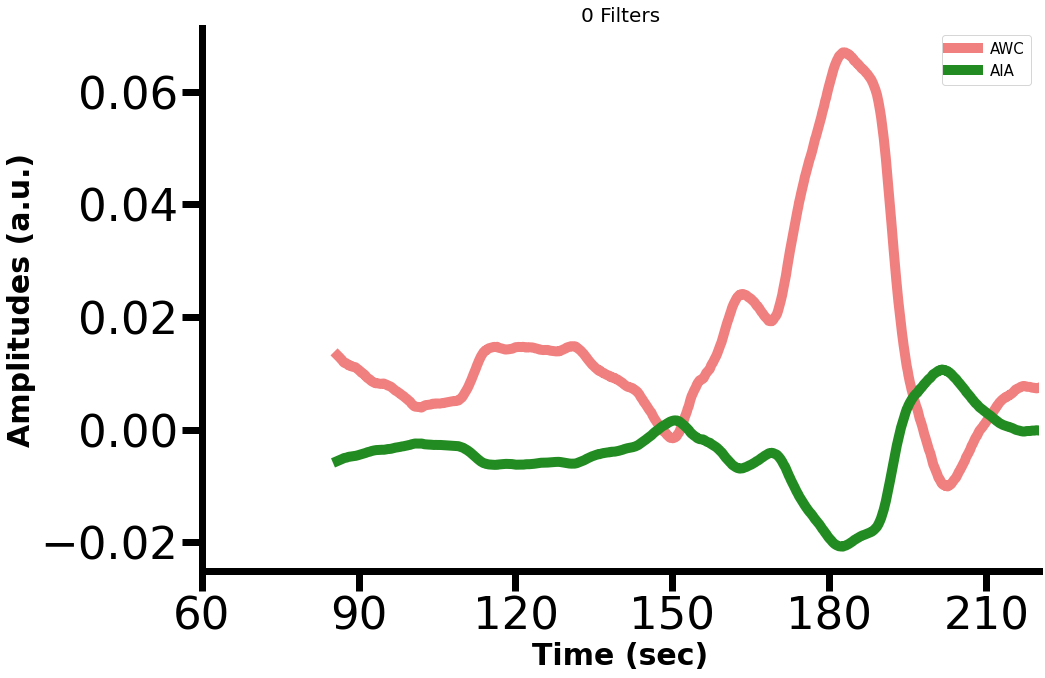

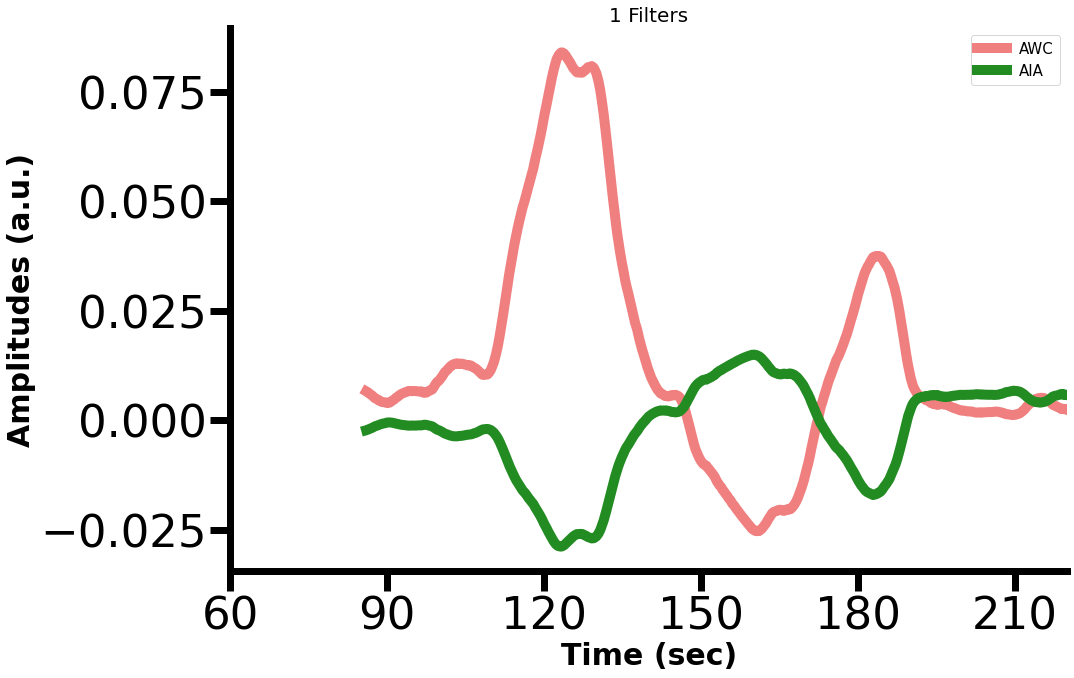

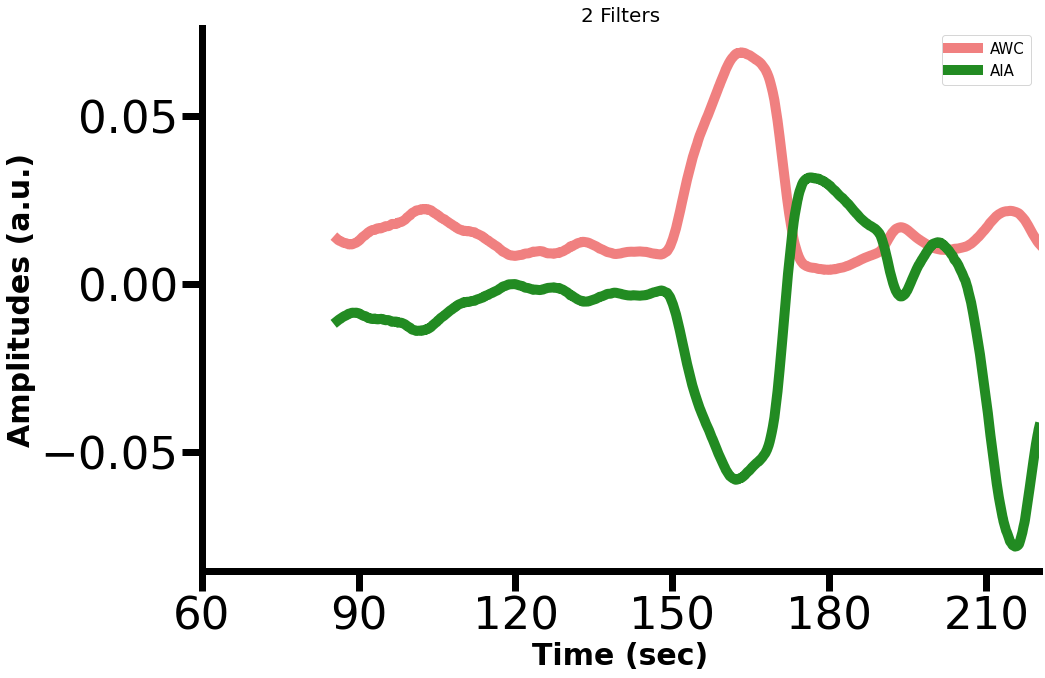

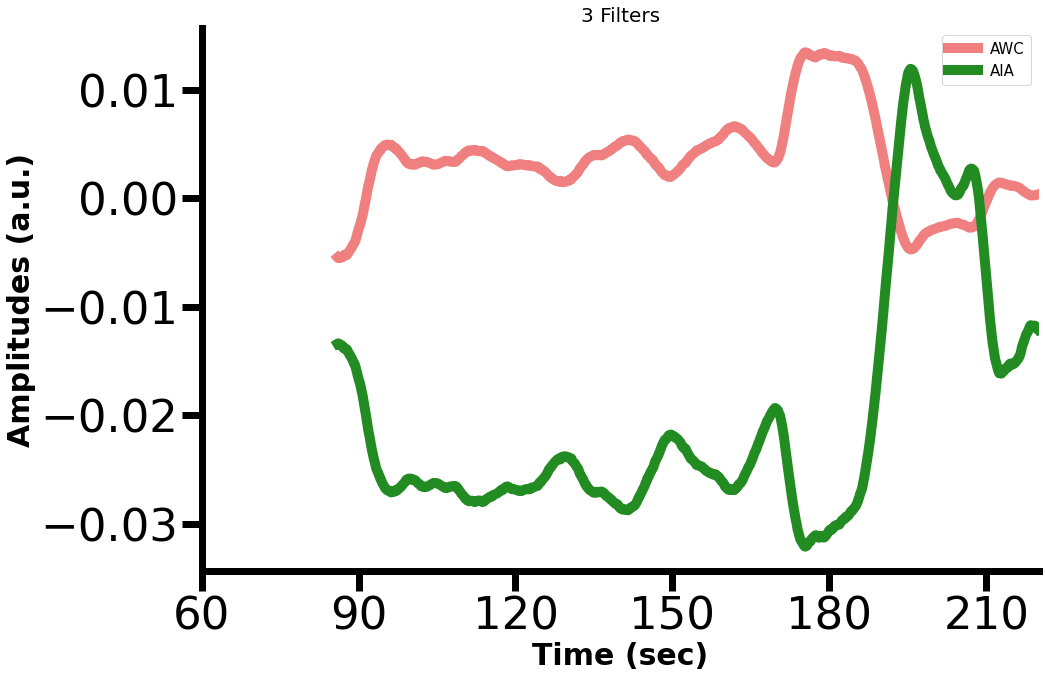

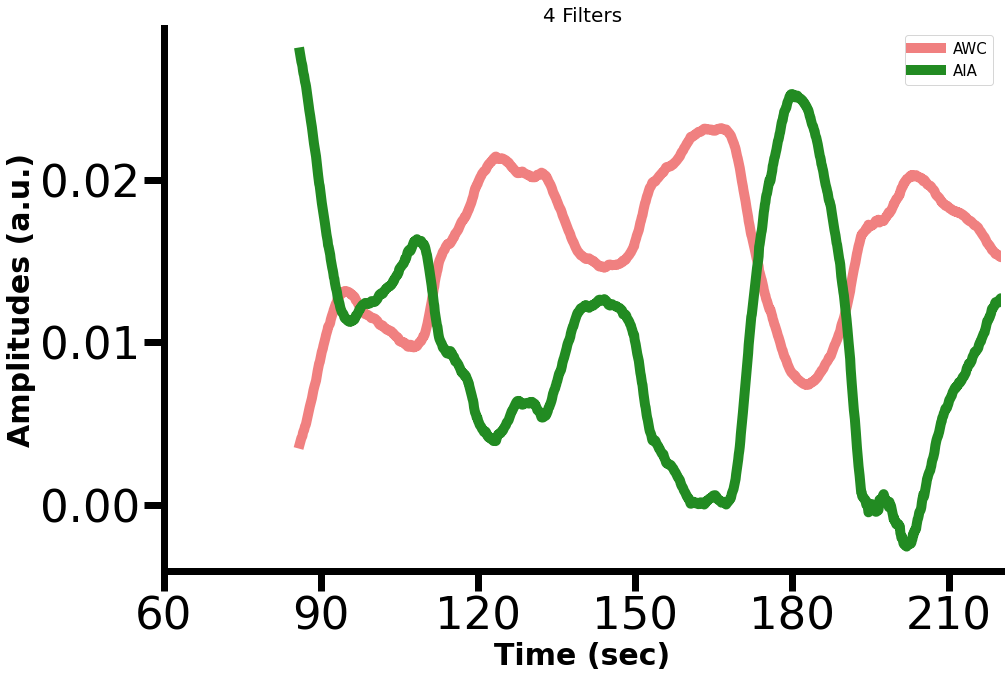

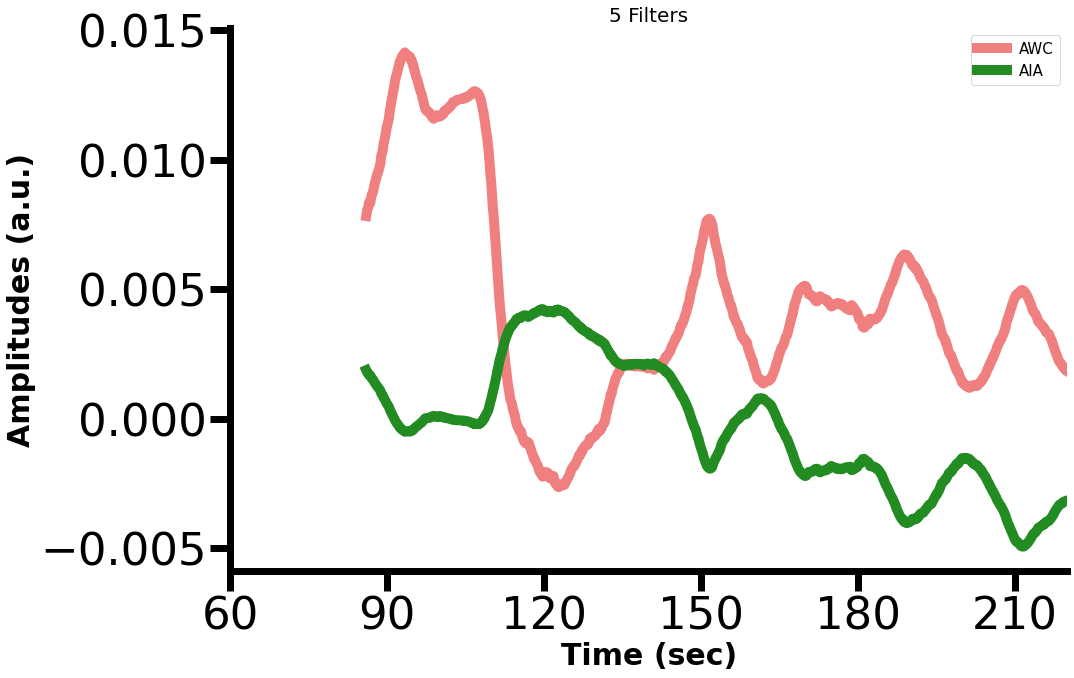

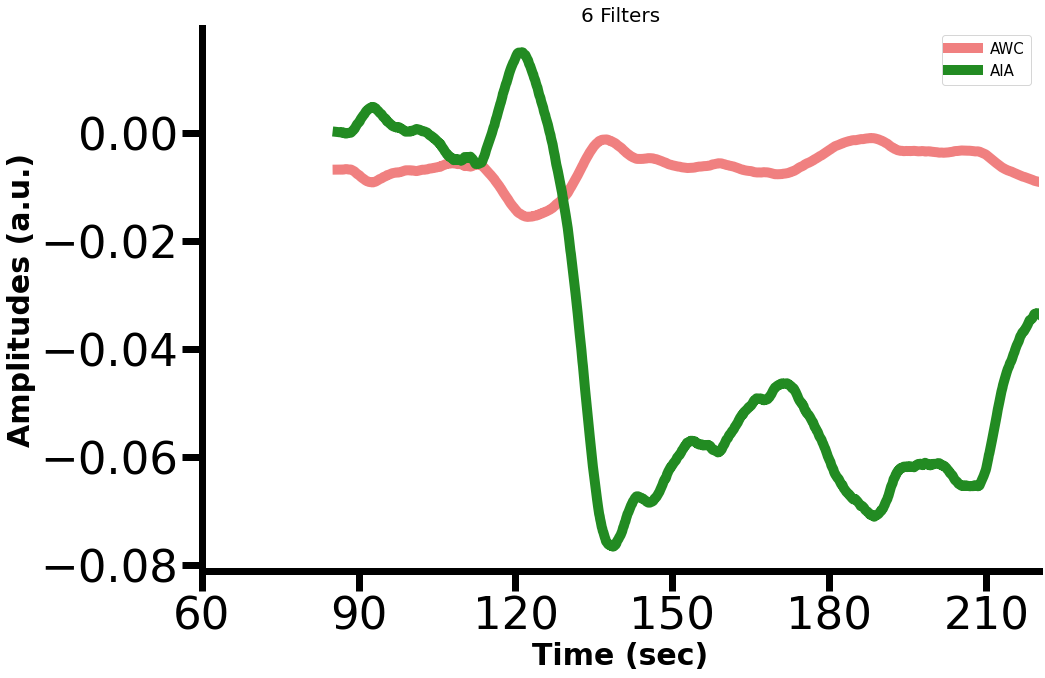

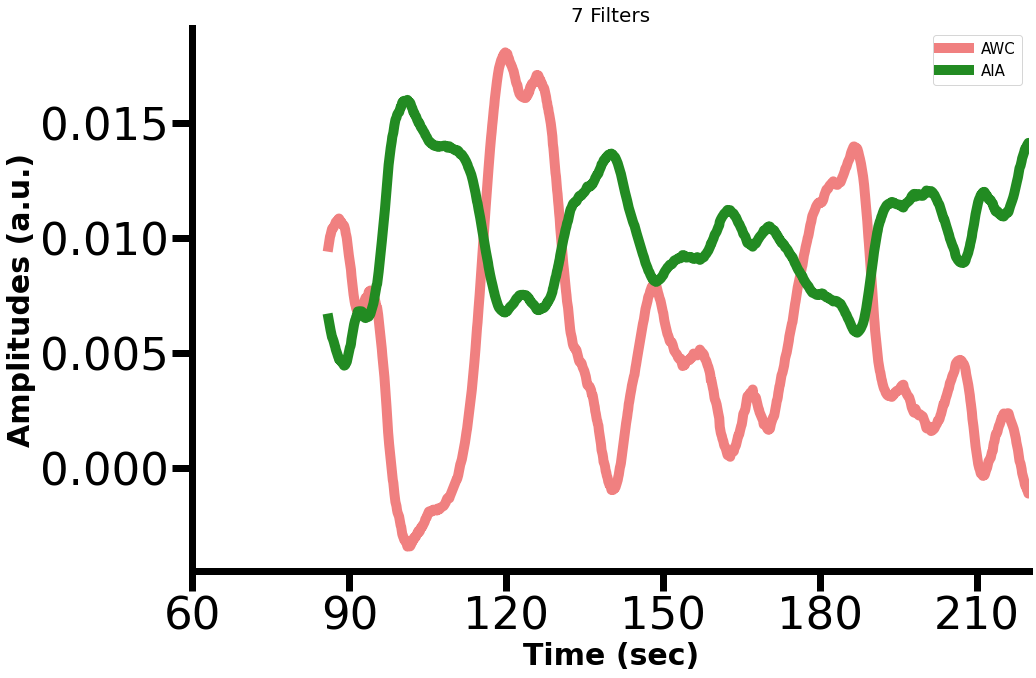

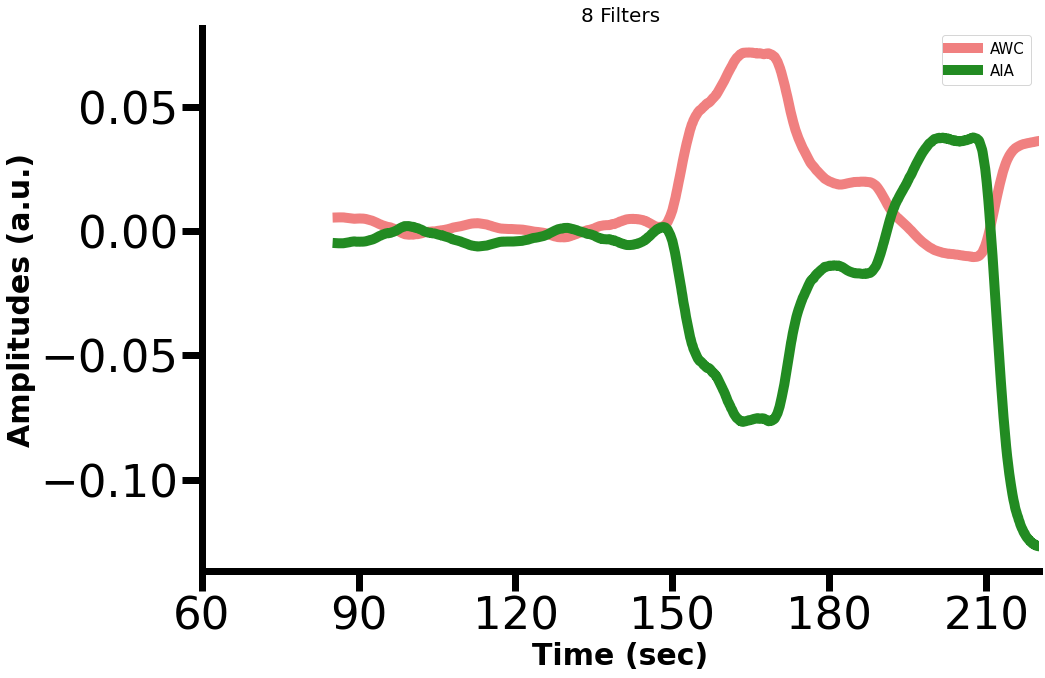

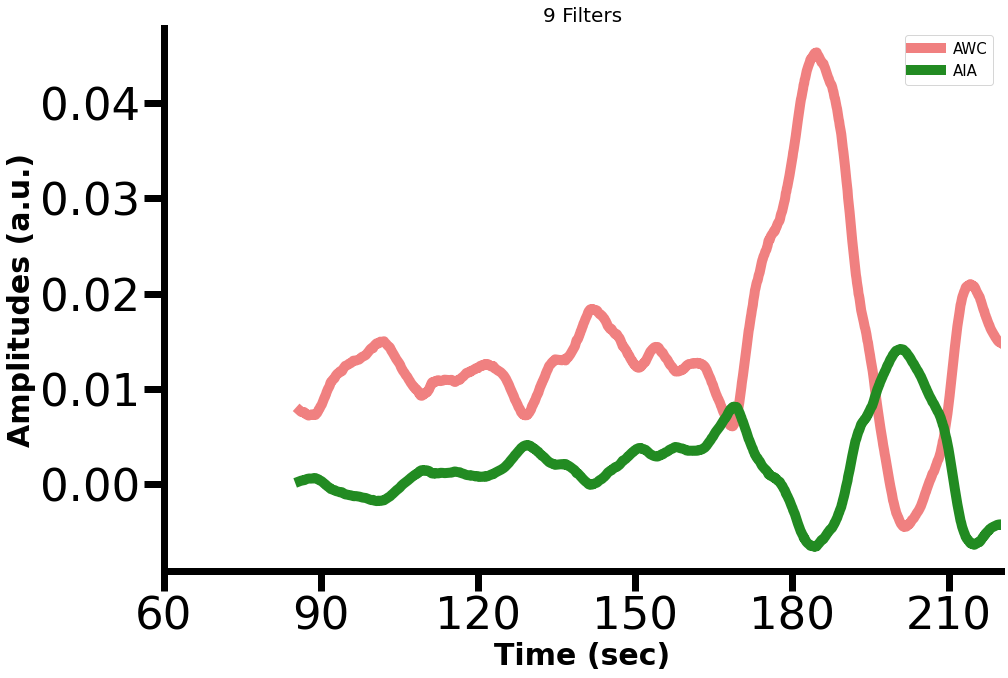

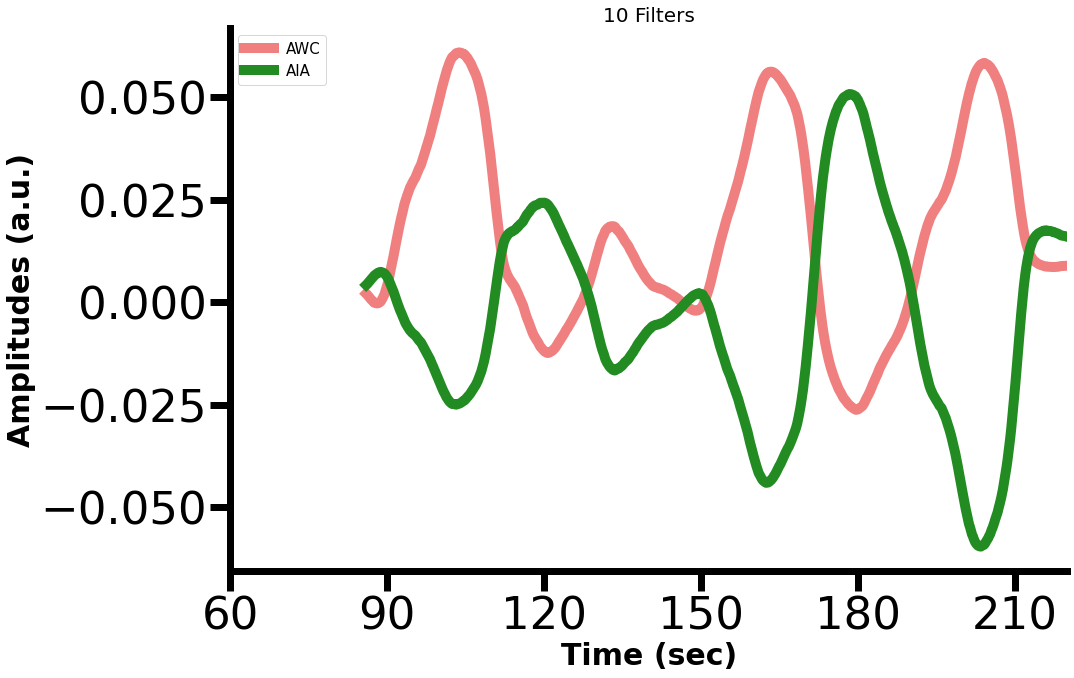

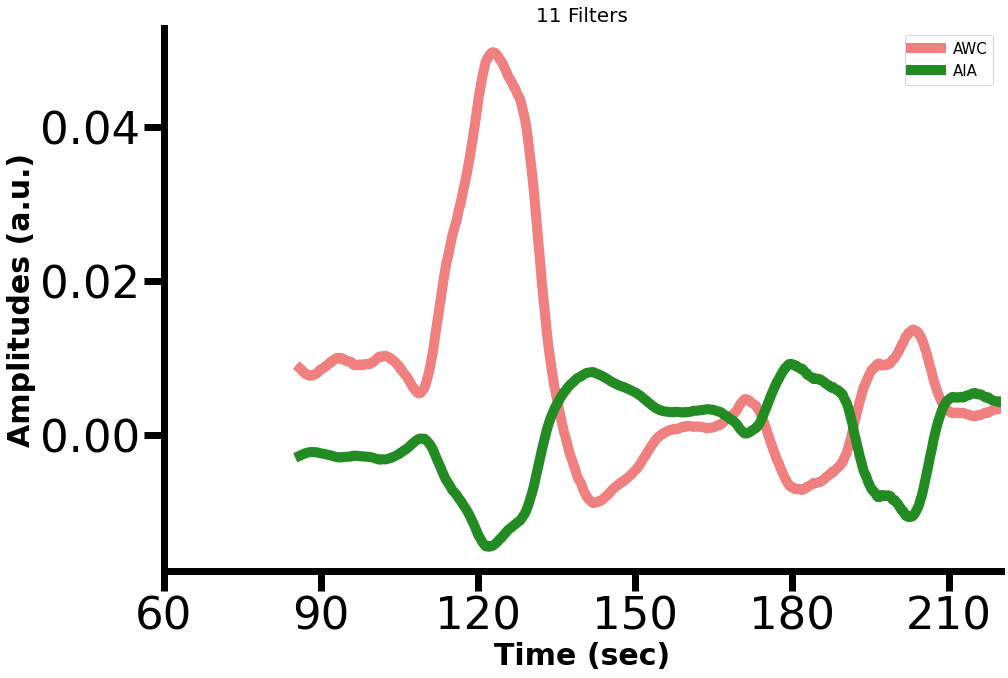

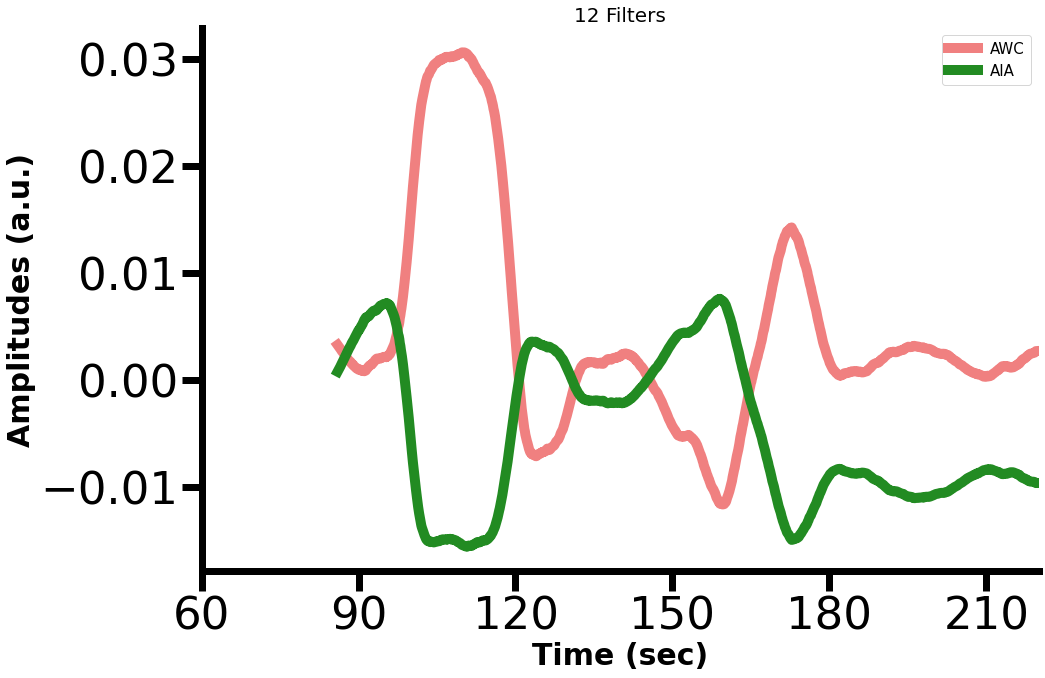

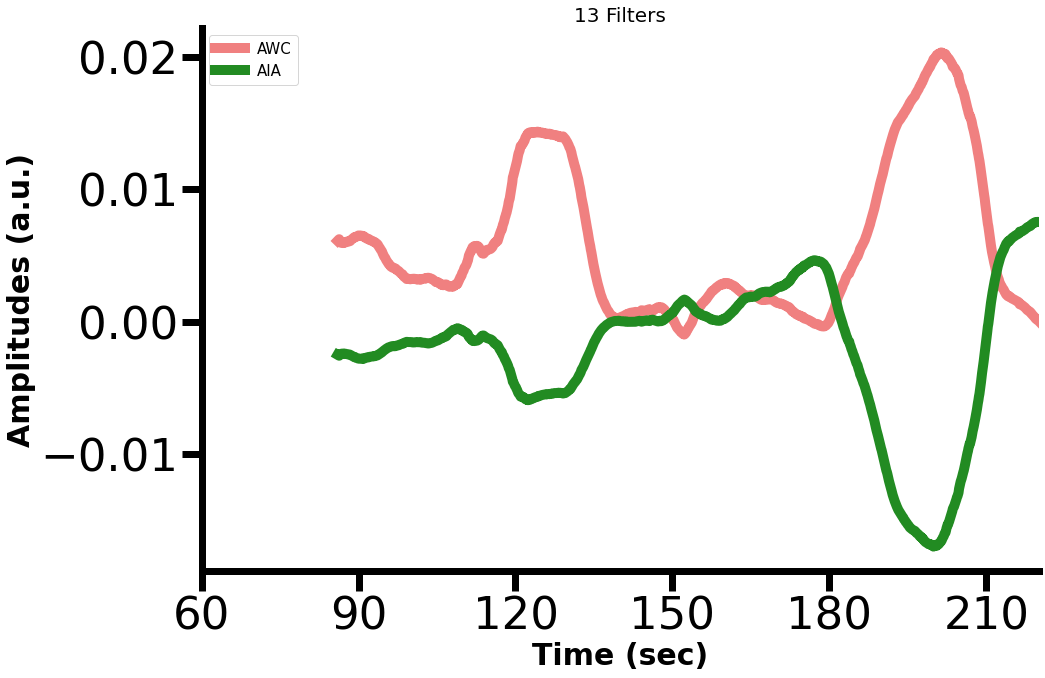

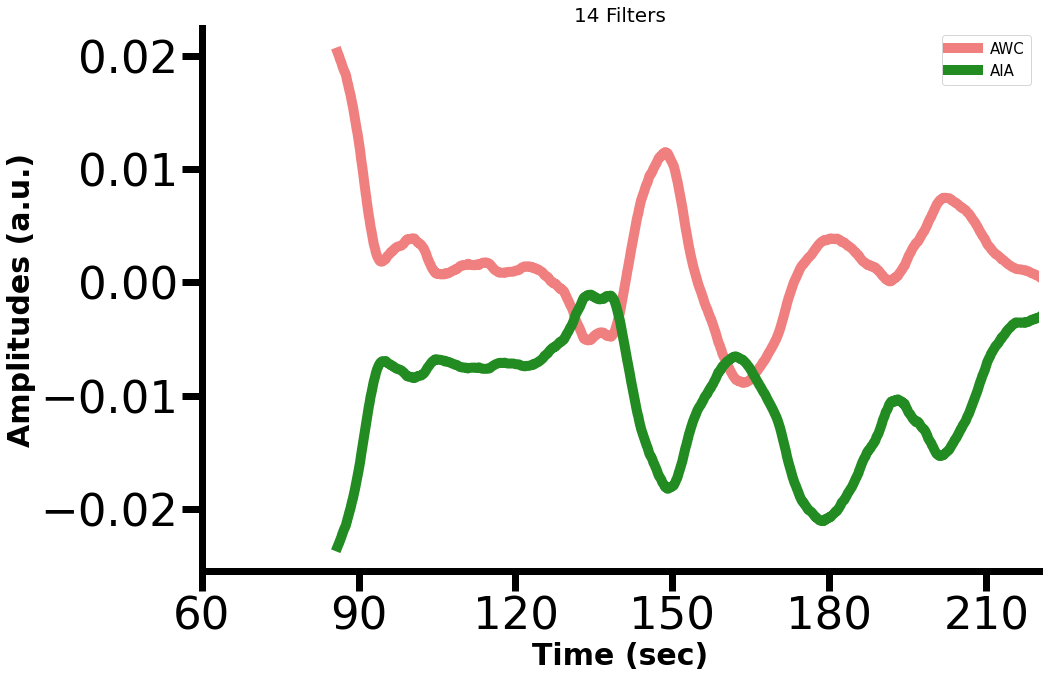

In [47]:
## Plotting -- Sliding amplitudes ##

# This will plot out the resulting AWC and AIA amplitudes that are being fit over time using the sliding window.
# During the fitting process, it is being divided by the fixed AVA amplitude, so you can either plot the raw
# AWC/AIA amplitudes, or their amplitudes normalized by AVA activity (used in the paper).

# For the length of the amplitude arrays, the length for each worm is the length of the full array (1940) minus 
# (sliding window time (500) - 1 = 499), totaling 1441 frames. 


## - Smoothing Traces - ##

# For plotting, we will smooth the sliding amplitudes to reduce jitter from fitting so that it's a continuous line.
# Process involves shifting each trace by a certain number 
# (I used 10 in the plotting for the paper, but 5 seems to be sufficient too without over-smoothing),
# where trace is shifted in the beginning and end by the same number, then averaged with original trace
# to produce new, smoothed trace.

def Smooth(array, shift): # we shift by some frames, too much will over-smooth and too little will not reduce noise
# I actually shifted by 10 frames for plotting, but 5 frames is sufficient too (couple noisy spots here and there)
    smoothed = [] 
    step = (2*shift) + 1 #total number of arrays from shifting, plus original array
    
    for a in array:
        temp = []

        for i in range(shift): #shift array one at a time
            plus = a[(i+1):]
            plus = np.append(plus, [np.nan]*(i+1)) #add nans at beginning

            minus = a[:-(i+1)]
            minus = np.insert(minus, 0, [np.nan]*(i+1)) #add nans at end

            temp.append(plus) #append beginning-shifted array
            temp.append(minus) #append end-shifted array

        temp.append(a) #append original array

        smooth = np.sum(temp, axis = 0) / step #average all arrays 
        smoothed.append(smooth[shift:-shift]) #cuts off nans in beginning and end from shifting
    
    return smoothed

def Sliding_amps(slide_amp, ava_amp, worm_num, shift, output):
    sliding_loss = 500 - 1
    len_slide_amp = len(WT_AIB_both[0]) - sliding_loss # establish new len of array, use aib len as reference
    
    new_len = len_slide_amp - (shift*2) # how much to shift for smoothing

    reshape_amps = np.reshape(slide_amp, (worm_num, len_slide_amp)) # need to reshape
    
    smooth_amp = Smooth(reshape_amps, shift) # smooth amps

    fxn = []
    
    for i in range(worm_num): # first smooth amps
        fxn_temp = []

        for j in range(new_len): # this will normalize to AVA activity using fixed AVA amplitude
            temp = smooth_amp[i][j] / ava_amp[i]
            fxn_temp.append(temp)
        fxn.append(fxn_temp)
        
    if output == 'raw amps': # return raw amps
        return reshape_amps
    if output == 'fraction': # return amps divided/normalized by AVA amp
        return fxn
    
     
sliding_AWC = Sliding_amps(WT_slide_AWC_amp, WT_AVA_sum_amps, WT_worm_num, 10, 'raw amps') 
fxn_AWC = Sliding_amps(WT_slide_AWC_amp, WT_AVA_sum_amps, WT_worm_num, 10, 'fraction') 

sliding_AIA = Sliding_amps(WT_slide_AIA_amp, WT_AVA_sum_amps, WT_worm_num, 10, 'raw amps') 
fxn_AIA = Sliding_amps(WT_slide_AIA_amp, WT_AVA_sum_amps, WT_worm_num, 10, 'fraction') 


timeplot = []
for p in range(860,2281): # cut off more of the beginning due to sliding window and convolution loss
    # if change smoothing, change numbers (+ or - smooth amount,+ or - smooth amount)
    temp = p/10
    timeplot.append(temp)

for i in range(WT_worm_num):
    fig, ax = plt.subplots(1,1, figsize=(15,10), facecolor='w') #ax1 for double plots
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 7
    ax.set_title(str(i)+' Filters', fontsize=20)
    ax.plot(timeplot, fxn_AWC[i], color = 'lightcoral', linewidth = 10, label = 'AWC')
    ax.plot(timeplot, fxn_AIA[i], color = 'forestgreen', linewidth = 10, label = 'AIA')
    ax.tick_params(axis= 'both', labelsize=45, length=20, width=7)
    ax.set_ylabel('Amplitudes (a.u.)', fontsize=30, weight='bold')
    ax.set_xlabel('Time (sec)', fontsize=30, weight='bold')
    ax.legend(loc='best', fontsize=15)
    #ax.set_ylim([-0.1,0.15])
    ax.set_xlim([60,220]) # this is to align with other plots
    plt.xticks(np.arange(60, 220, step=30))
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
